In [1]:
import numpy as np
import pandas as pd
import sys
import gc
import joblib
import pathlib
import json
import glob
from tqdm.notebook import tqdm

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
sns.set_context("talk")
style.use('seaborn-colorblind')

import plotly.graph_objects as go

In [2]:
df = pd.read_csv("/Users/sandeep/Workspace/APEX/RecoveryStocksArbitrage/Yash_Recovery_Stocks.csv")
df = df.drop(index = 72)
df

Ticker                          Name  Total Return:M-6  \
0   BASE US Equity                 COUCHBASE INC            -30.70   
1    SPT US Equity   SPROUT SOCIAL INC - CLASS A            -30.92   
2   ASAN US Equity              ASANA INC - CL A            -31.53   
3     XM US Equity  QUALTRICS INTERNATIONAL-CL A            -32.03   
4   RPAY US Equity           REPAY HOLDINGS CORP            -32.19   
..             ...                           ...               ...   
67   API US Equity                 AGORA INC-ADR            -70.62   
68    KC US Equity   KINGSOFT CLOUD HOLDINGS-ADR            -74.03   
69  STNE US Equity                 STONECO LTD-A            -74.32   
70  TUYA US Equity                      TUYA INC            -75.15   
71  OCFT US Equity   ONECONNECT FINANCIAL TECHNO            -78.05   

    Rev - 1 Yr Gr:Q    Market Cap  Market Cap.1  Price:D-1    P/E  
0             20.16  9.150515e+08  9.150515e+08      20.99    NaN  
1             45.82  3.414239e+09  3.414239e+09      63.22    NaN  
2             70.34  8.948612e+09  8.948612e+09      48.00    NaN  
3             47.98  1.543719e+10  1.543719e+10      27.06    NaN  
4             62.42  1.552755e+09  1.552755e+09      17.15    NaN  
..              ...           ...           ...        ...    ...  
67            46.00  1.083391e+09  1.083391e+09       9.35    NaN  
68            39.62  1.781101e+09  1.781101e+09       7.37    NaN  
69            57.30  4.528934e+09  4.528934e+09      14.66  19.15  
70            44.85  2.783783e+09  2.783783e+09       4.96    NaN  
71            20.78  6.941885e+08  6.941885e+08       1.78    NaN  

[72 rows x 8 columns]

In [3]:
df['Ticker'] = df['Ticker'].replace("", "US Equity")
df = df.replace(to_replace=r' US Equity', value='', regex=True)
df

Ticker                          Name  Total Return:M-6  Rev - 1 Yr Gr:Q  \
0    BASE                 COUCHBASE INC            -30.70            20.16   
1     SPT   SPROUT SOCIAL INC - CLASS A            -30.92            45.82   
2    ASAN              ASANA INC - CL A            -31.53            70.34   
3      XM  QUALTRICS INTERNATIONAL-CL A            -32.03            47.98   
4    RPAY           REPAY HOLDINGS CORP            -32.19            62.42   
..    ...                           ...               ...              ...   
67    API                 AGORA INC-ADR            -70.62            46.00   
68     KC   KINGSOFT CLOUD HOLDINGS-ADR            -74.03            39.62   
69   STNE                 STONECO LTD-A            -74.32            57.30   
70   TUYA                      TUYA INC            -75.15            44.85   
71   OCFT   ONECONNECT FINANCIAL TECHNO            -78.05            20.78   

      Market Cap  Market Cap.1  Price:D-1    P/E  
0   9.150515e+08  9.150515e+08      20.99    NaN  
1   3.414239e+09  3.414239e+09      63.22    NaN  
2   8.948612e+09  8.948612e+09      48.00    NaN  
3   1.543719e+10  1.543719e+10      27.06    NaN  
4   1.552755e+09  1.552755e+09      17.15    NaN  
..           ...           ...        ...    ...  
67  1.083391e+09  1.083391e+09       9.35    NaN  
68  1.781101e+09  1.781101e+09       7.37    NaN  
69  4.528934e+09  4.528934e+09      14.66  19.15  
70  2.783783e+09  2.783783e+09       4.96    NaN  
71  6.941885e+08  6.941885e+08       1.78    NaN  

[72 rows x 8 columns]

In [4]:
import yfinance as yf

# Data gathering
historical_data = dict()

# map ticker labels to their corresponding 3mo historical data
for ticker in df['Ticker']:
    ticker = ticker.replace(" ","")
    #Lets look at the last 3m of data
    data = yf.Ticker(ticker).history(period = '3mo')
    # Add day of the week so we can start to see weekly patterns
    data = data.reset_index(0)
    data['Dayofweek'] = pd.to_datetime(data['Date']).dt.dayofweek
    data = data.drop(columns=['High','Low','Dividends', 'Stock Splits'])
    data['Intraday'] = data['Close'] / data['Open']
    data = data.reindex(columns = ['Date', 'Dayofweek', 'Open', 'Close', 'Volume', 'Intraday'])
    historical_data[ticker] = data


In [14]:
# Here are some of the algorithms we will use to backtest potential trading strategies. 
def backtest(df, day):
    # We will start with 1000 usd.
    # This backtest will test buying shares at market open and selling at market close on certain days of the week only.
    usd = 1000
    profits = []
    for i in range(len(df)):
        if df['Dayofweek'].values[i] == day:
            # buy
            pos_volume = usd / df['Open'].values[i]
            profits.append(pos_volume * (df['Close'].values[i] - df['Open'].values[i]))
    return profits

def plot_profits(ticker, profits, day):
    plt.figure()
    profits = np.array(profits)
    plt.plot(np.cumsum(profits))
    winp = np.sum(profits > 0) / len(profits)
    plt.xlabel('week')
    plt.ylabel('profits (USD)')
    plt.title(f'Current Ticker = {ticker} P(win) = {winp:.3f} on day {day}')

<ipython-input-14-a40bb10ae7d4>:15: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Empty DataFrame
Columns: []
Index: []

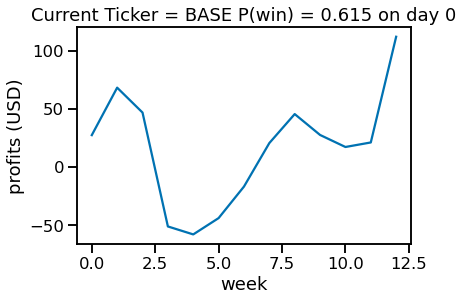

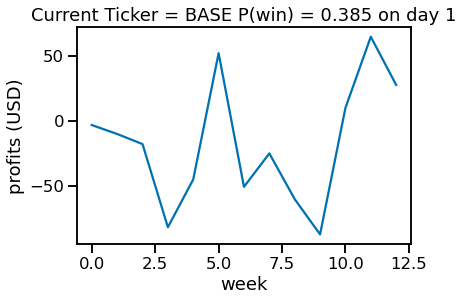

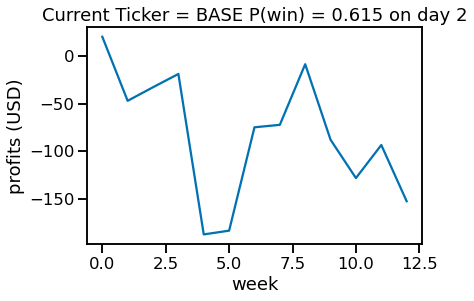

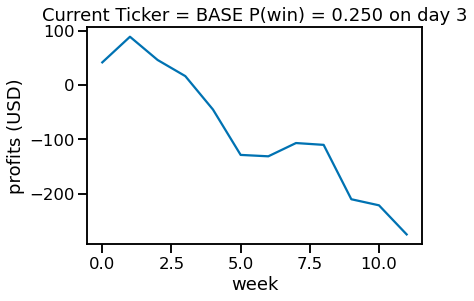

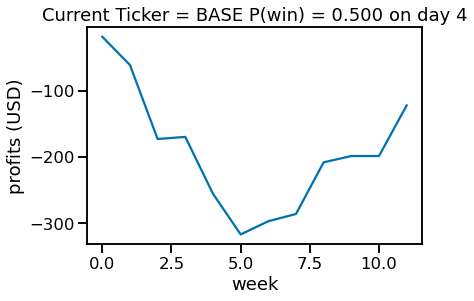

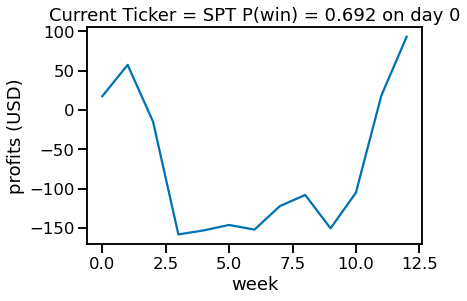

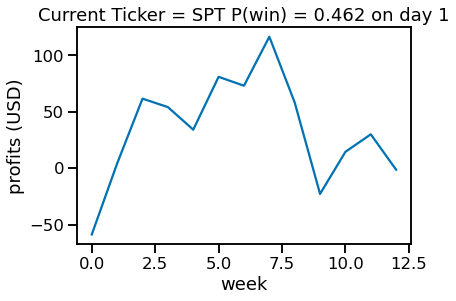

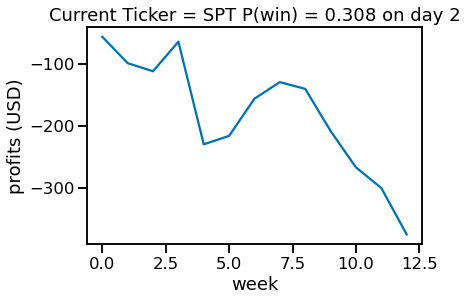

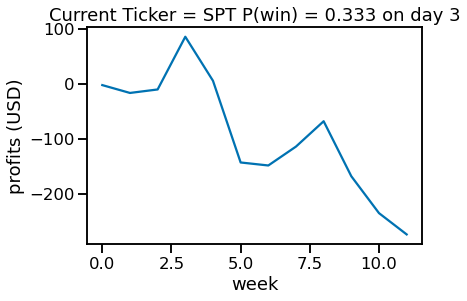

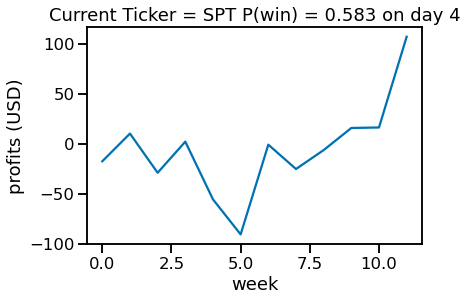

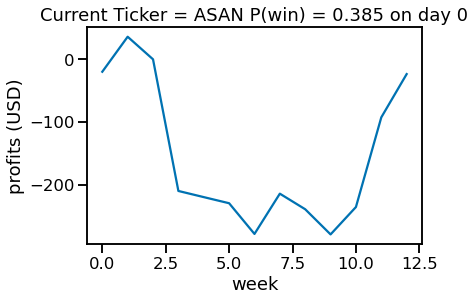

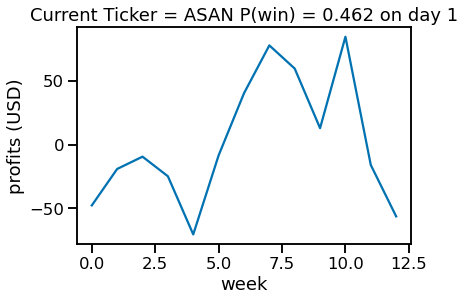

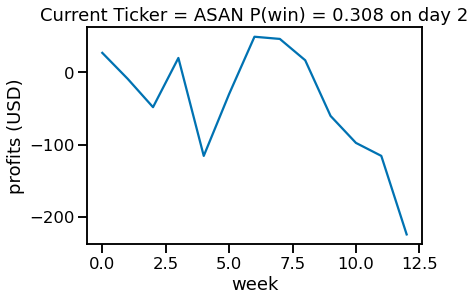

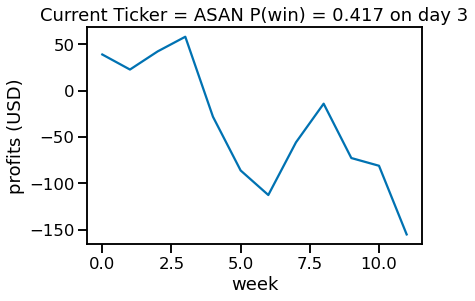

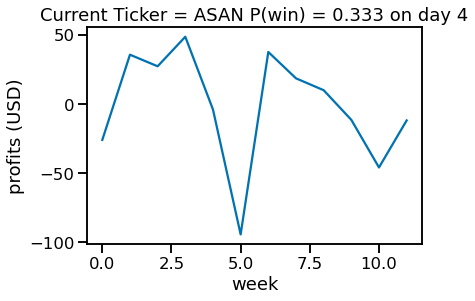

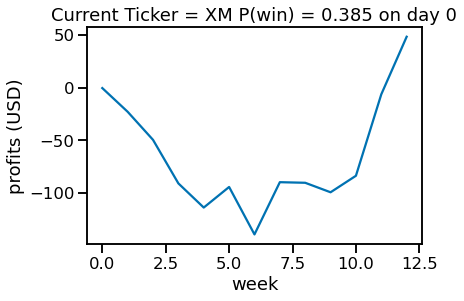

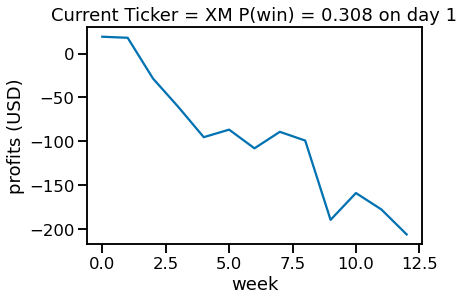

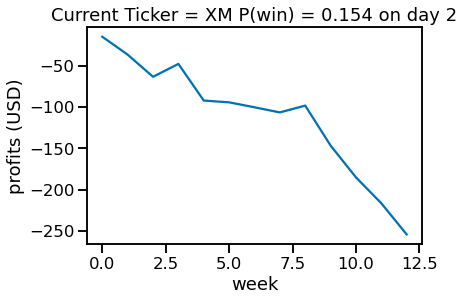

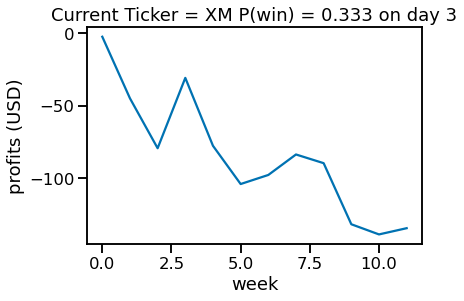

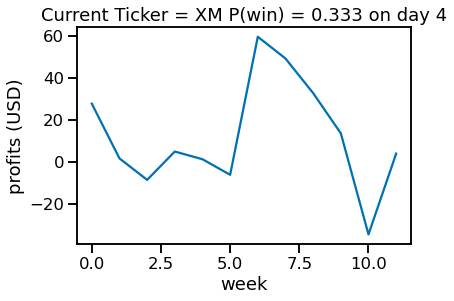

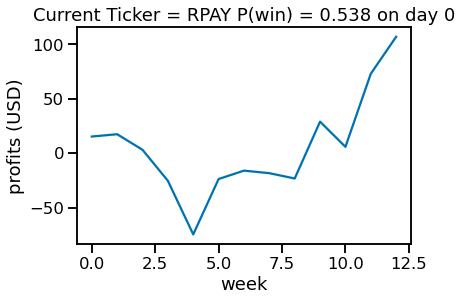

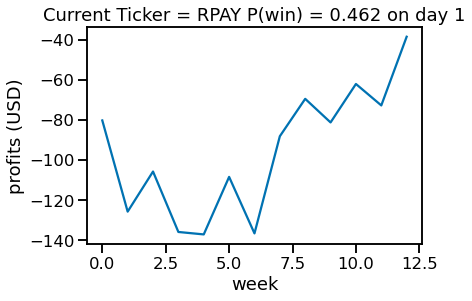

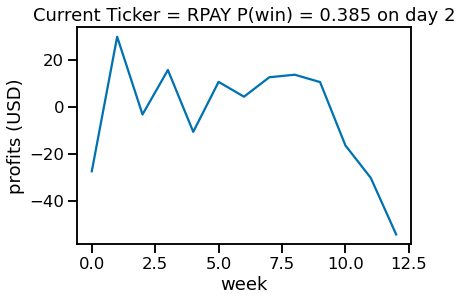

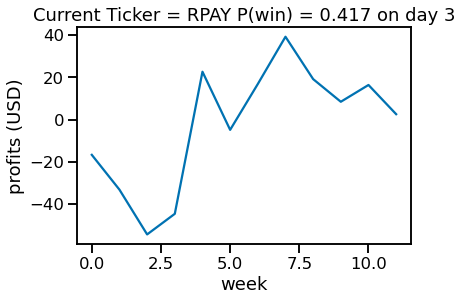

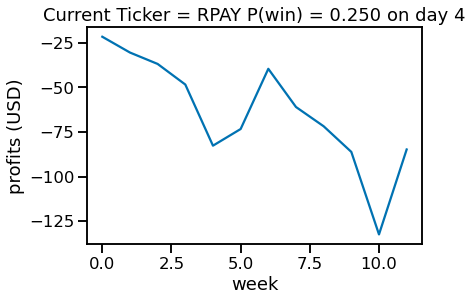

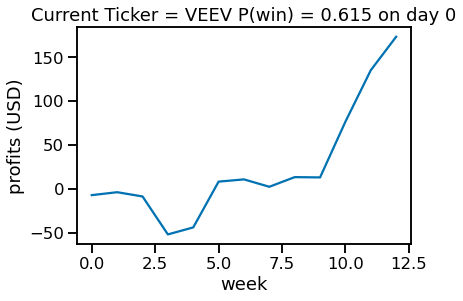

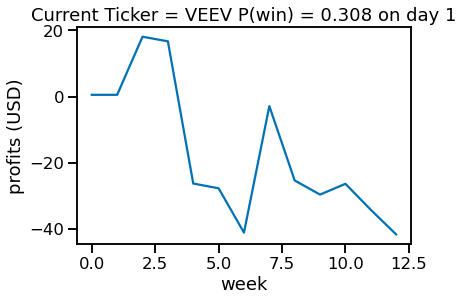

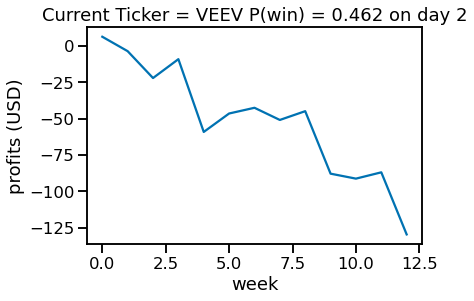

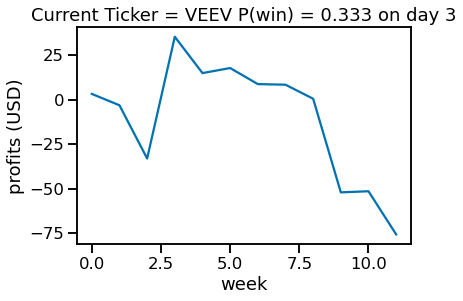

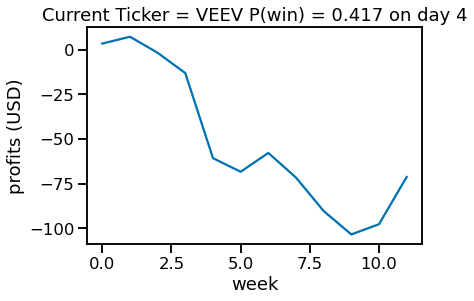

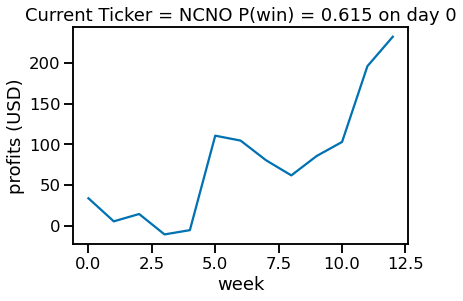

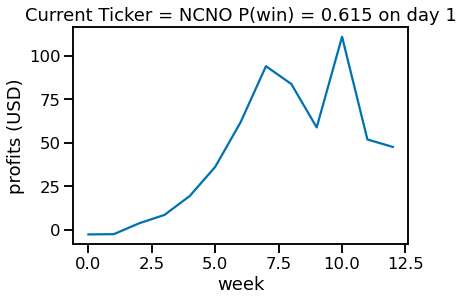

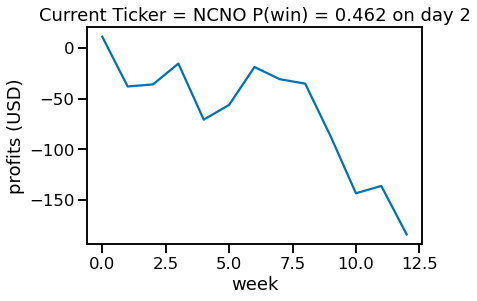

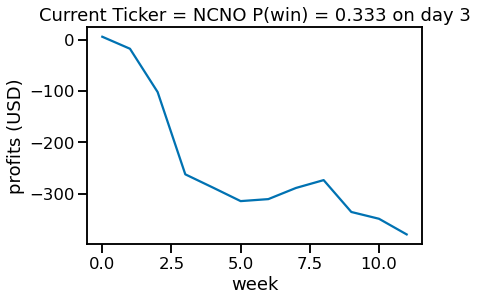

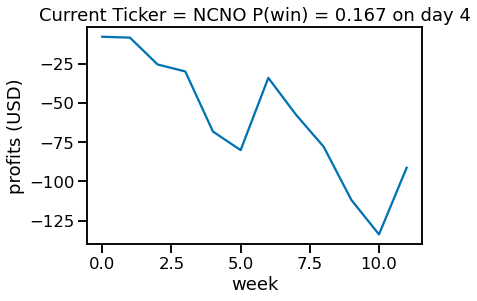

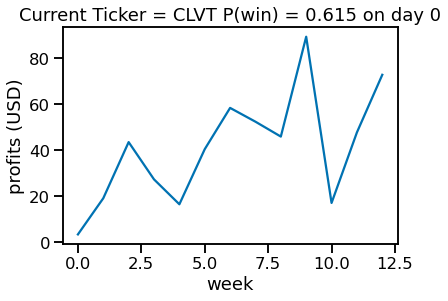

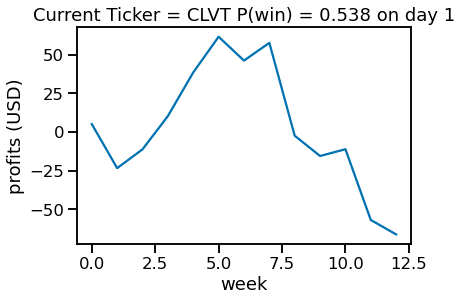

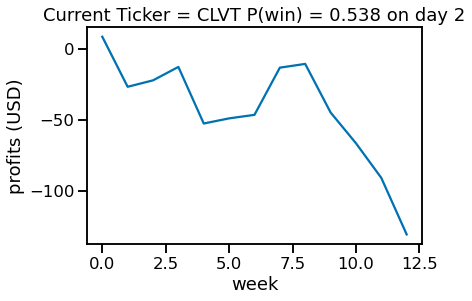

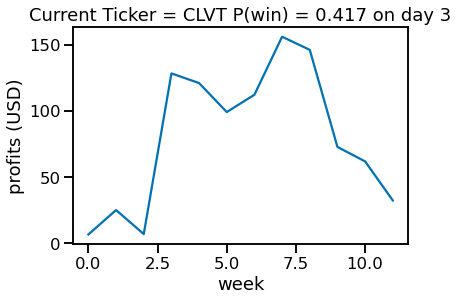

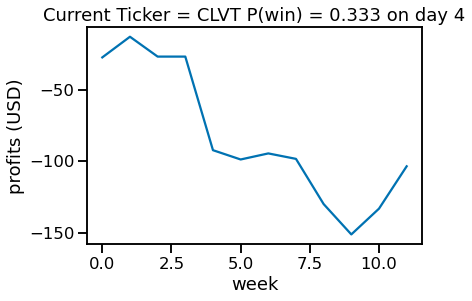

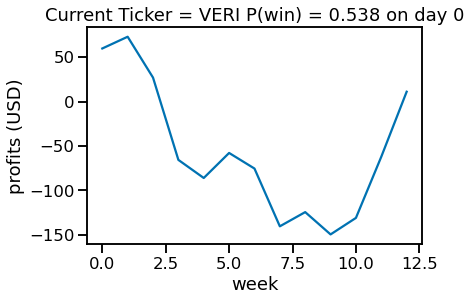

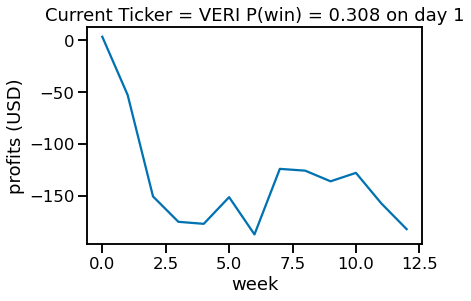

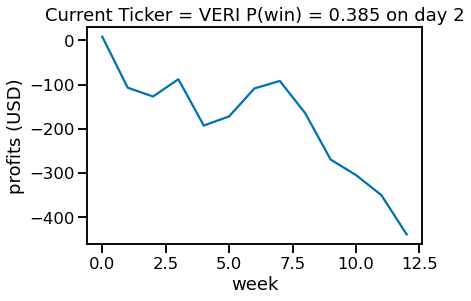

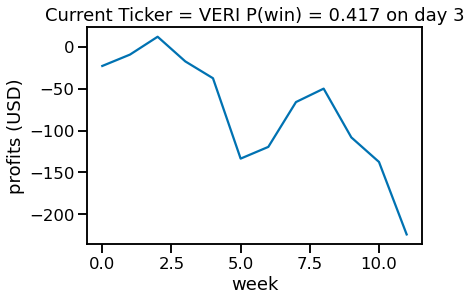

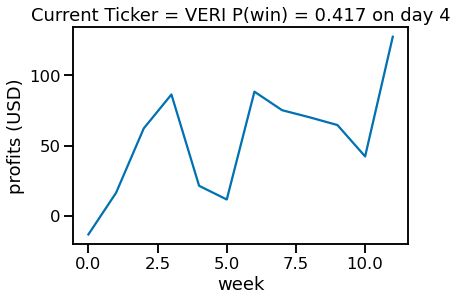

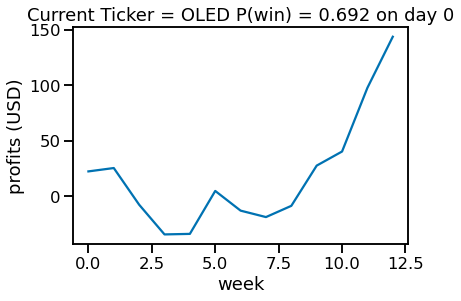

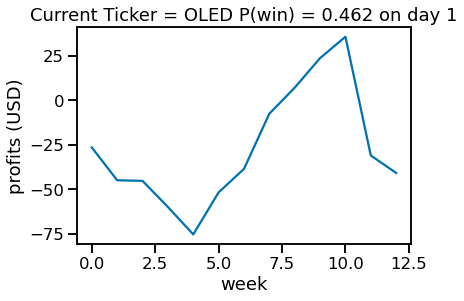

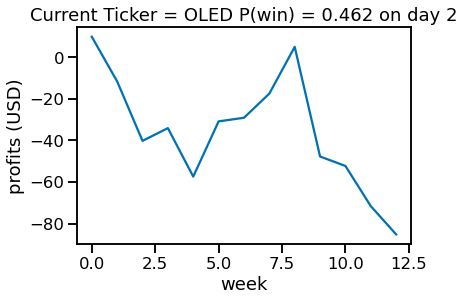

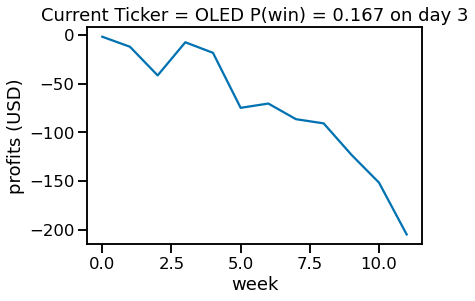

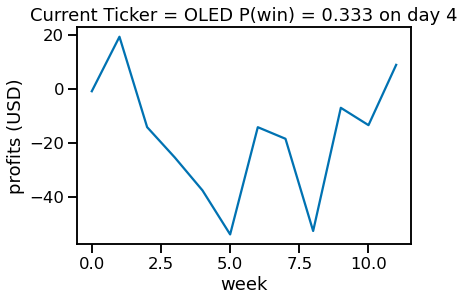

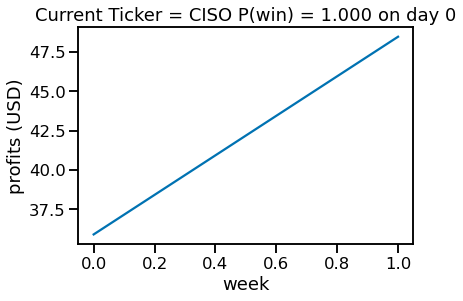

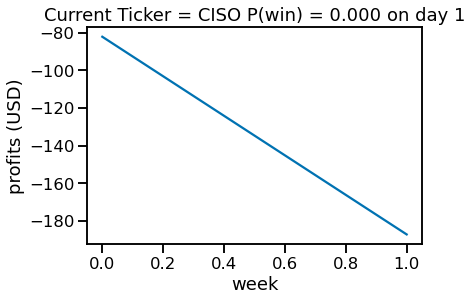

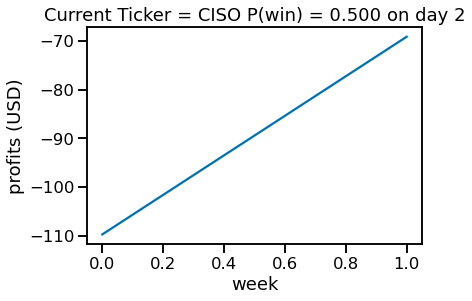

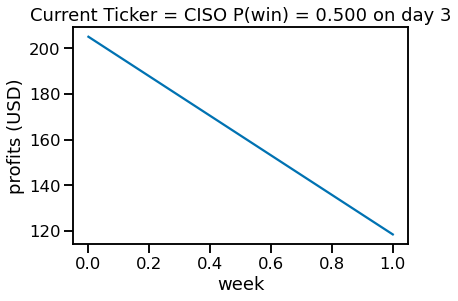

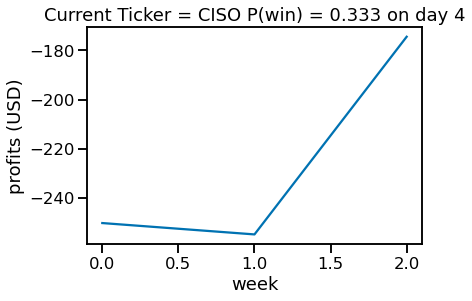

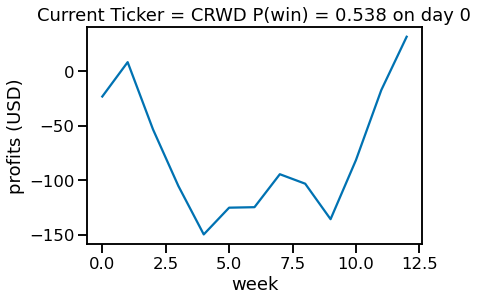

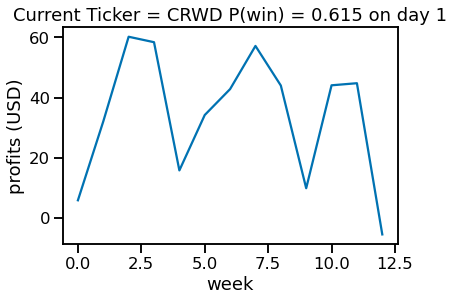

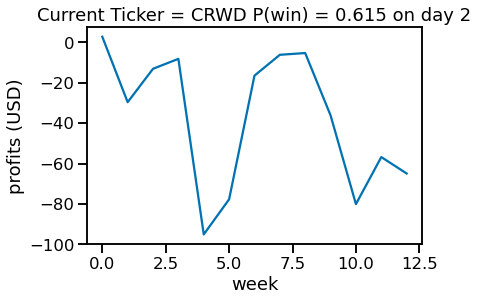

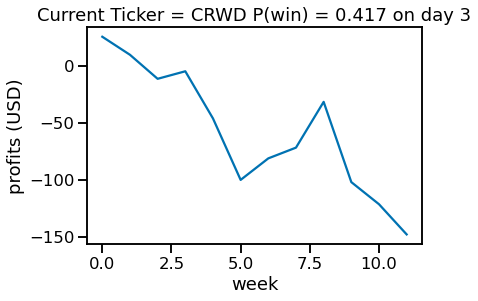

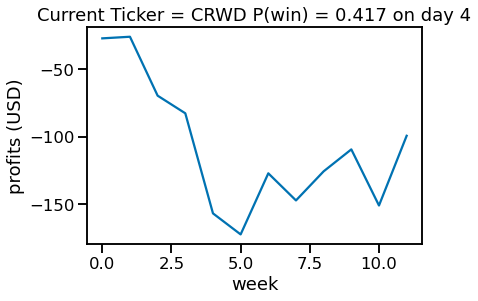

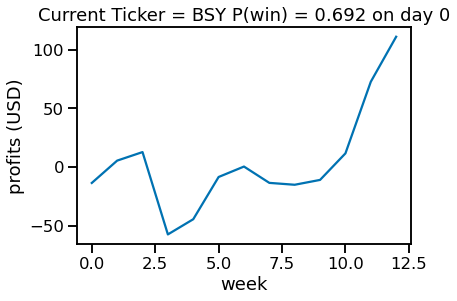

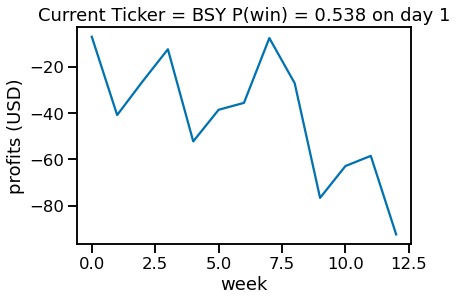

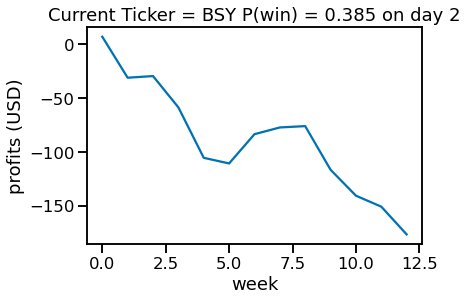

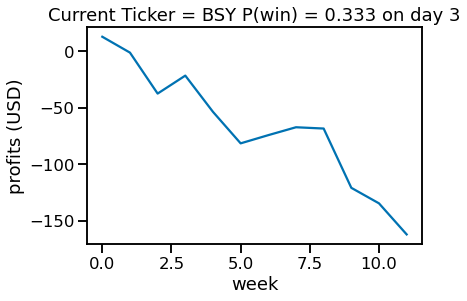

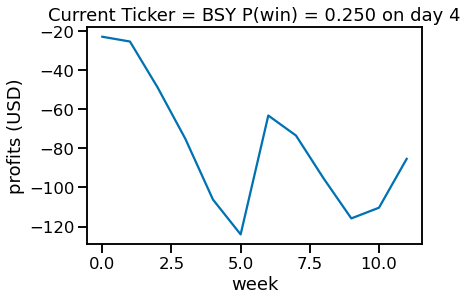

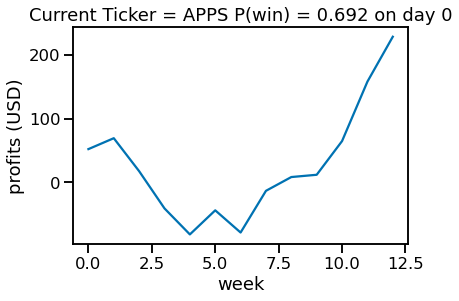

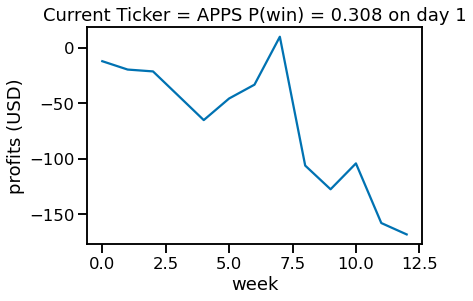

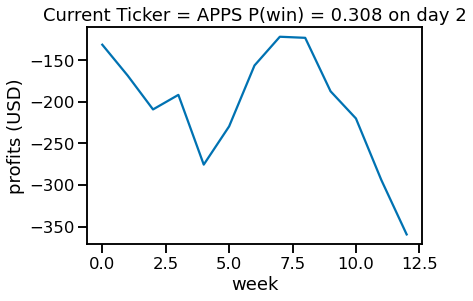

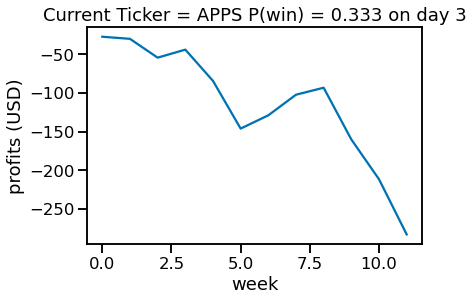

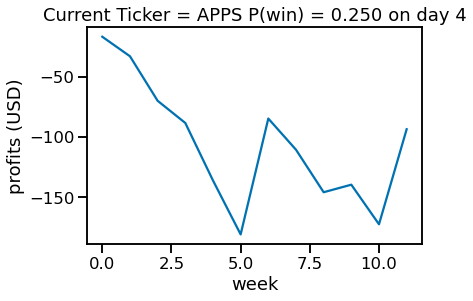

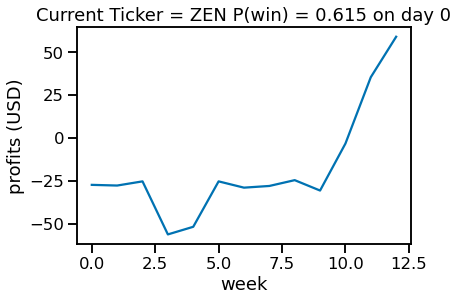

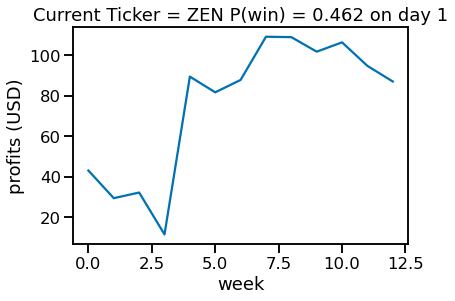

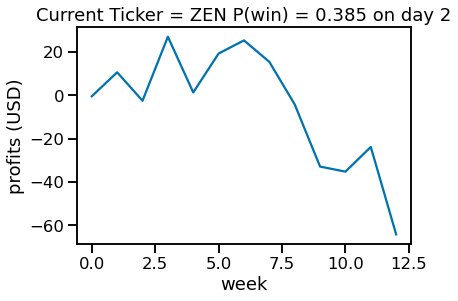

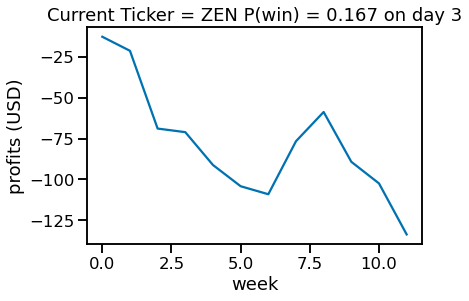

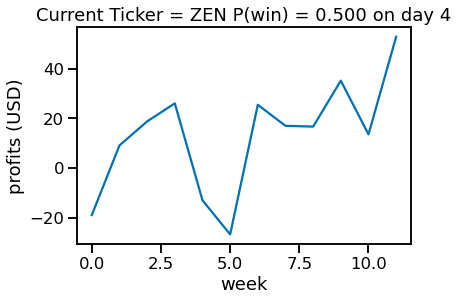

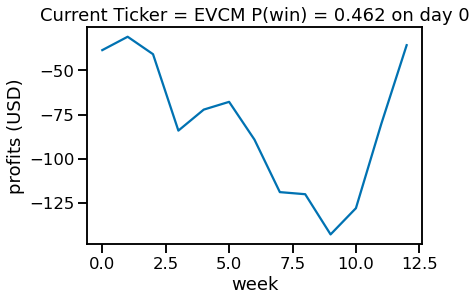

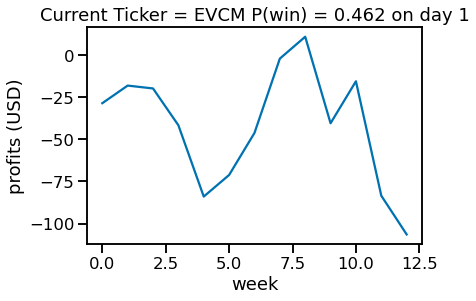

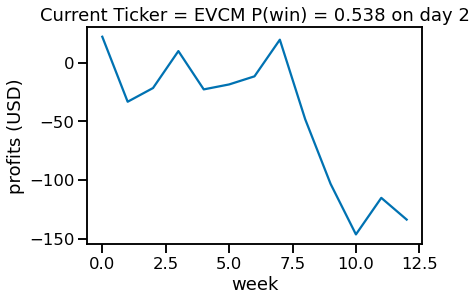

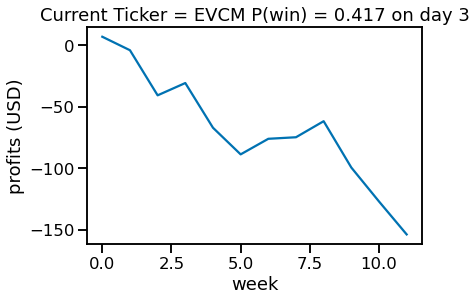

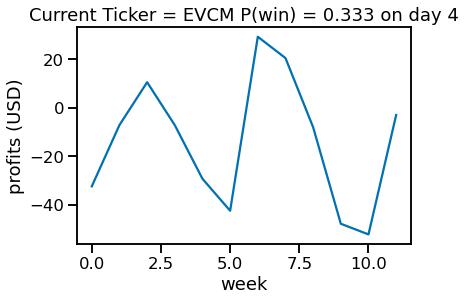

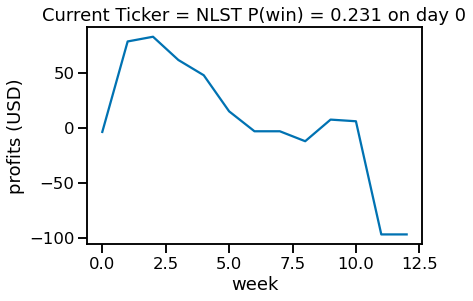

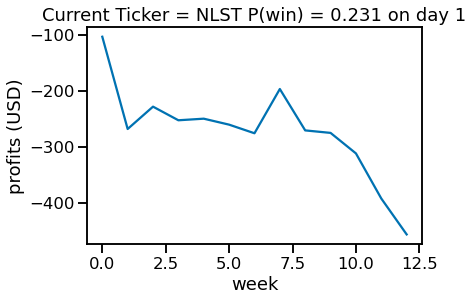

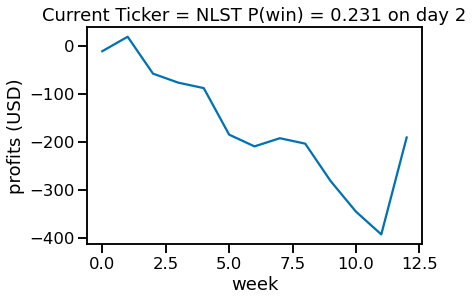

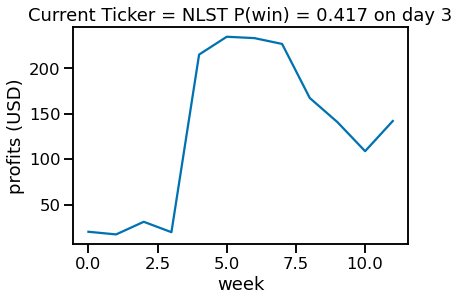

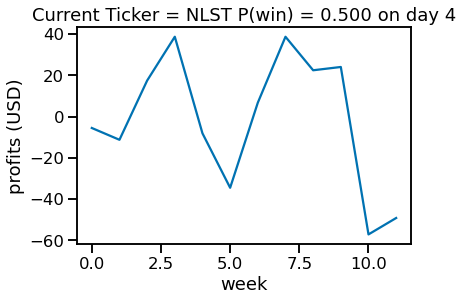

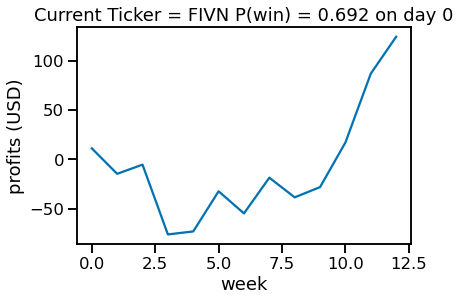

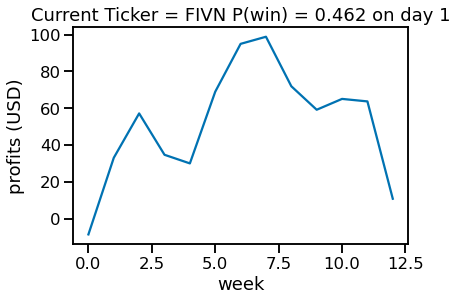

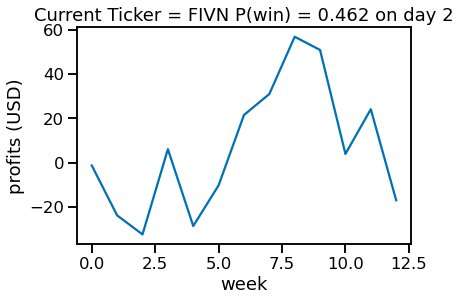

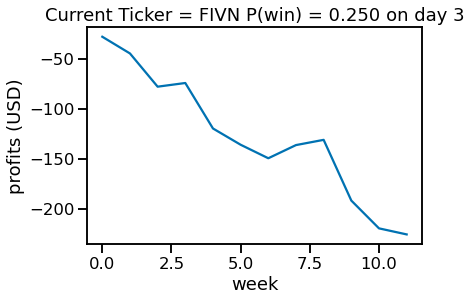

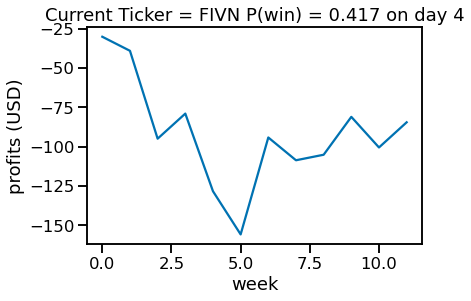

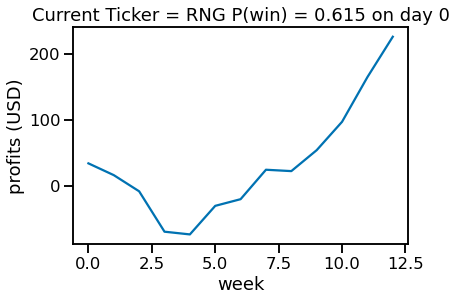

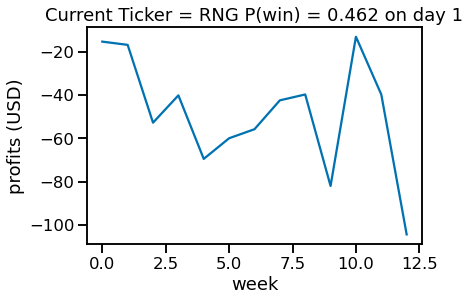

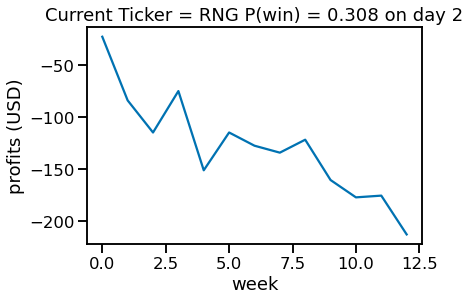

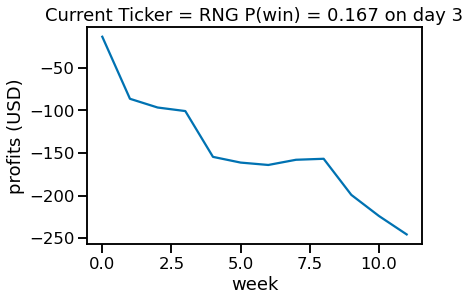

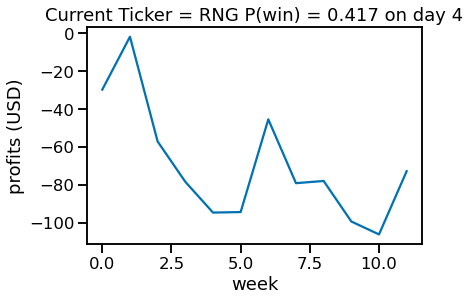

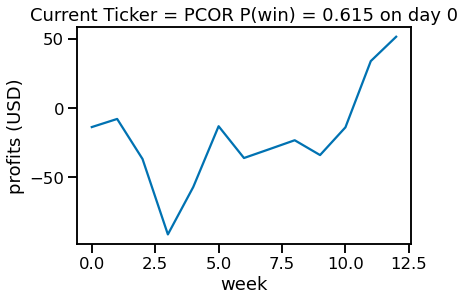

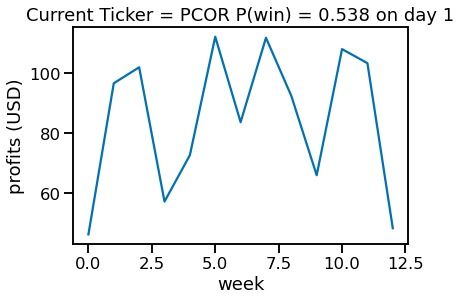

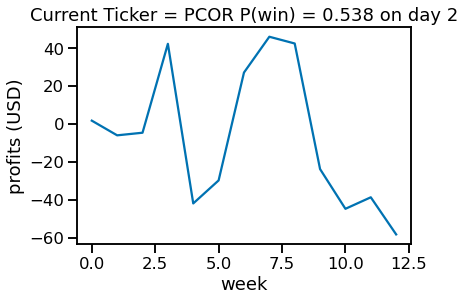

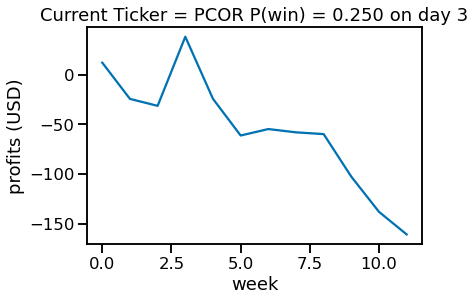

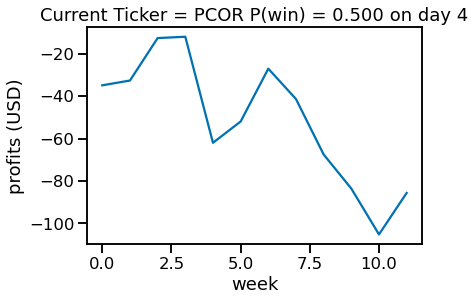

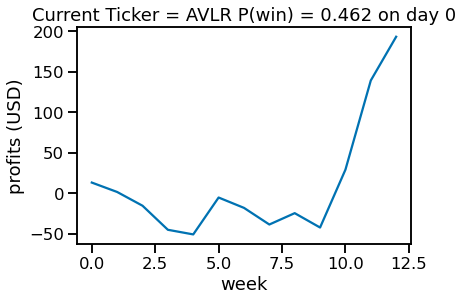

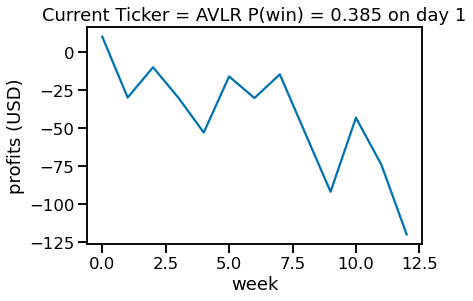

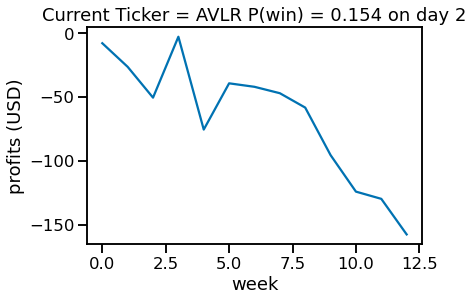

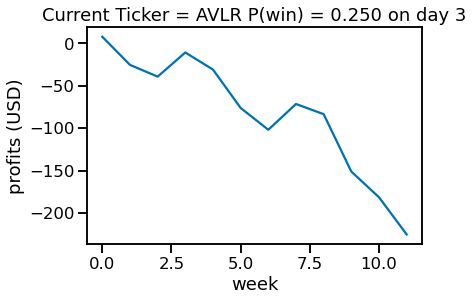

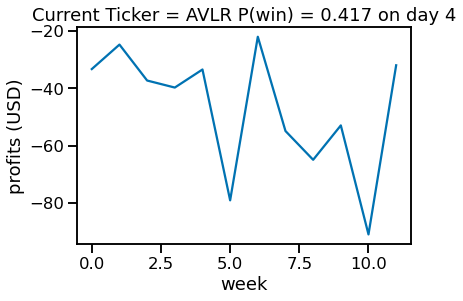

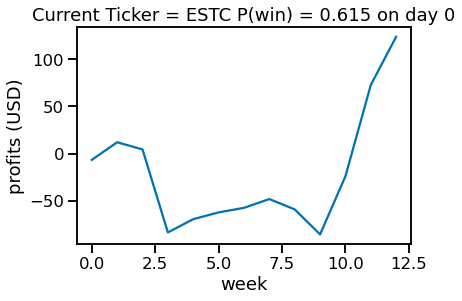

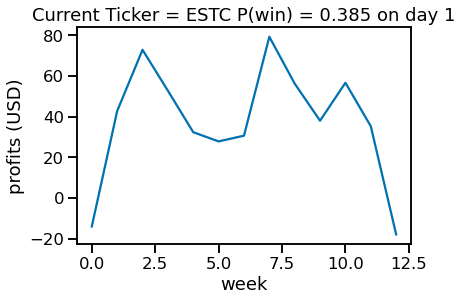

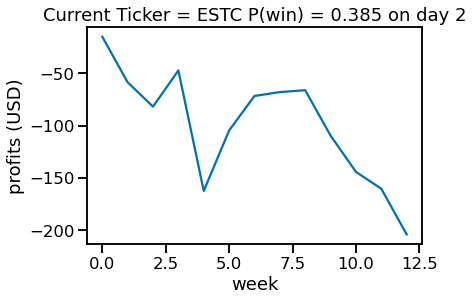

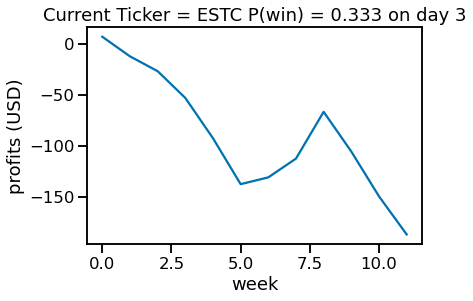

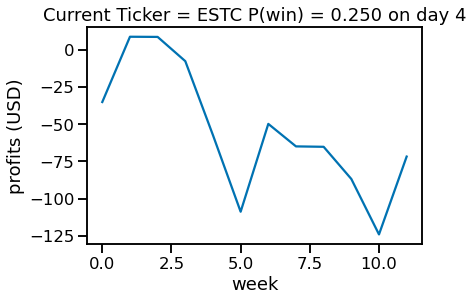

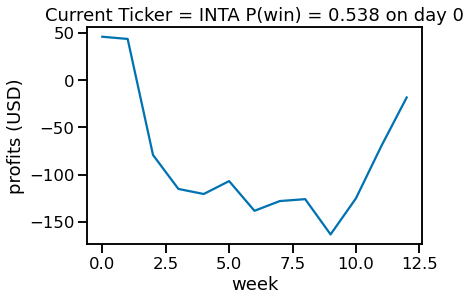

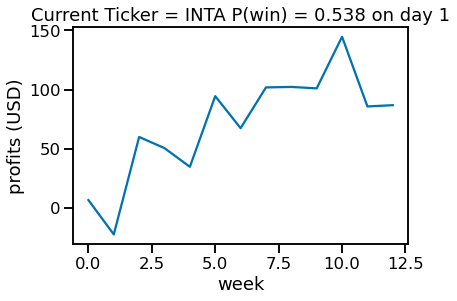

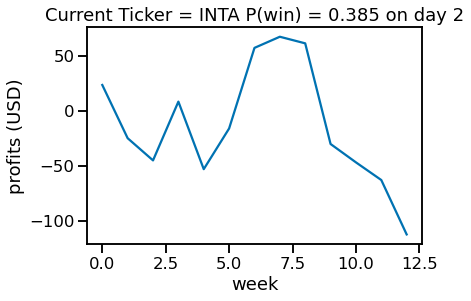

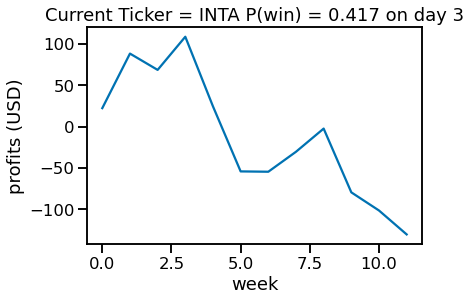

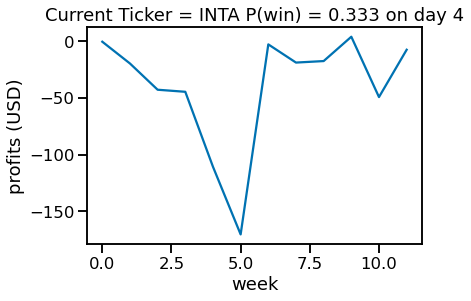

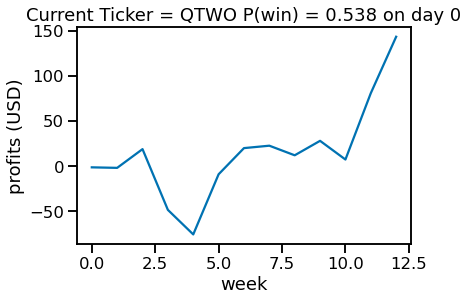

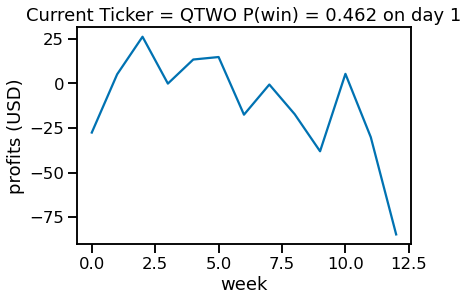

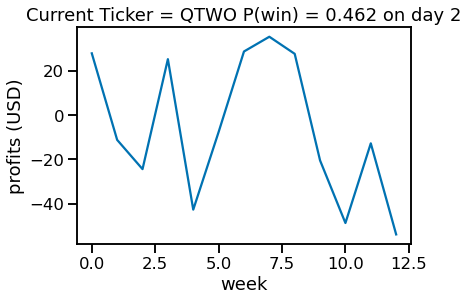

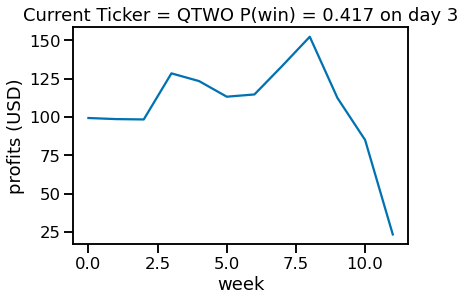

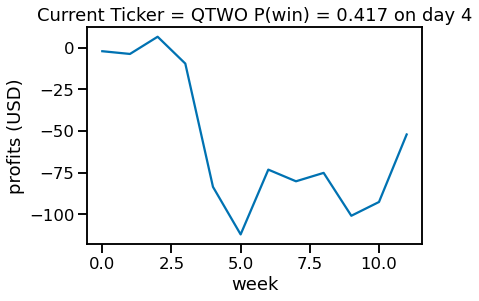

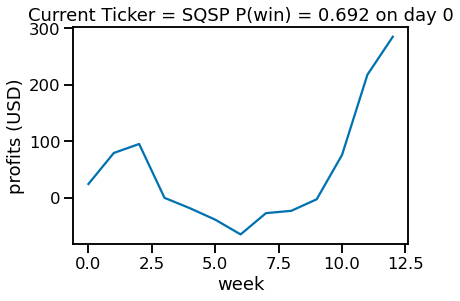

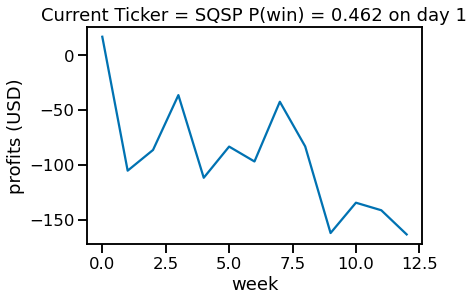

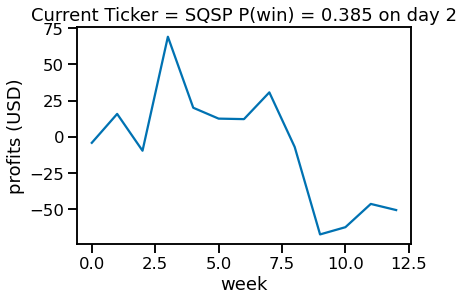

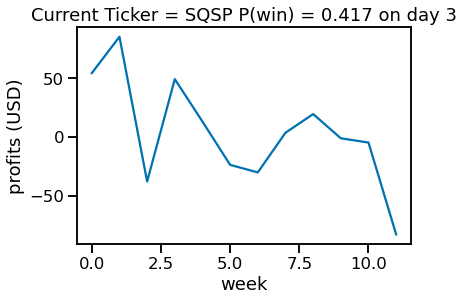

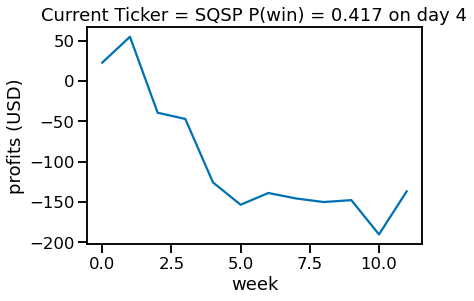

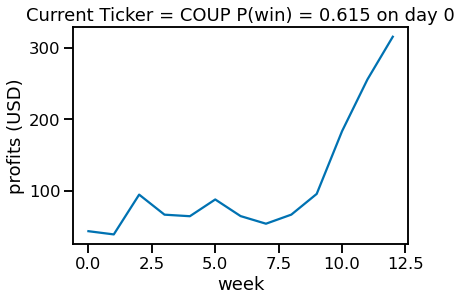

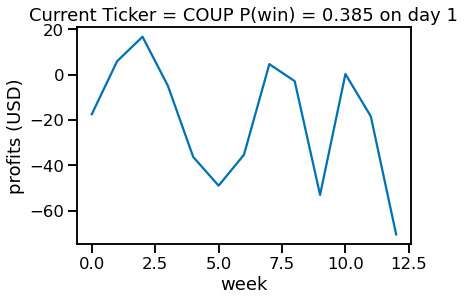

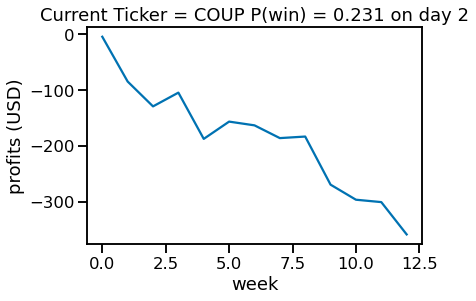

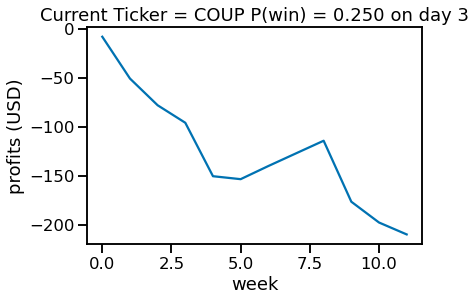

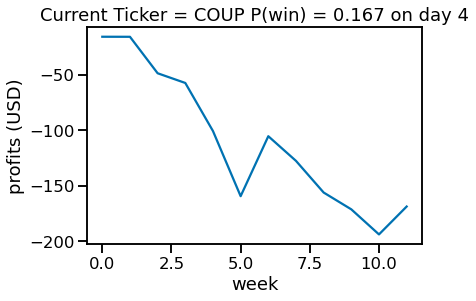

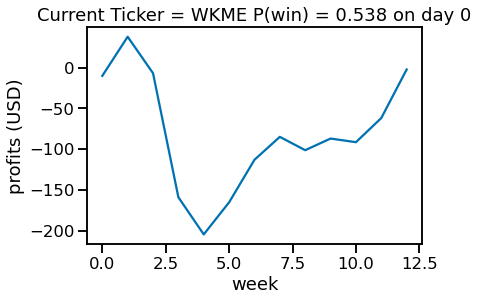

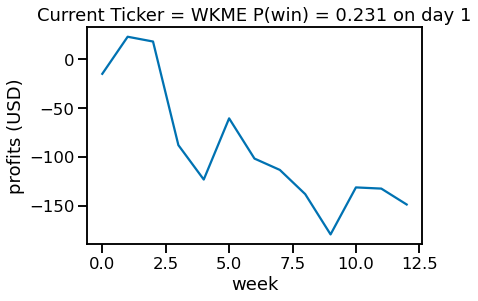

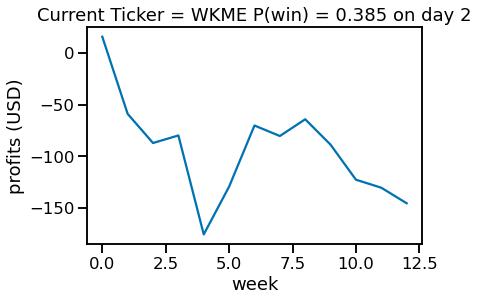

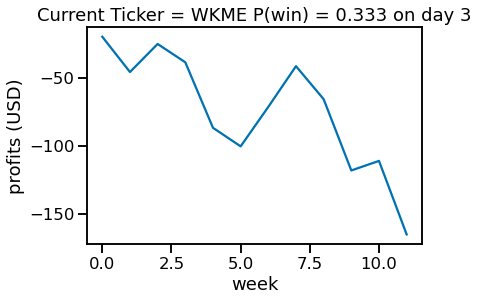

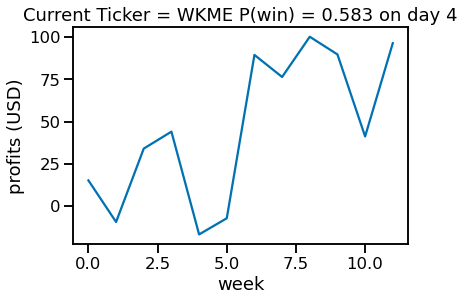

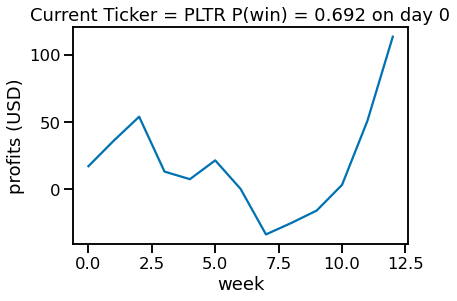

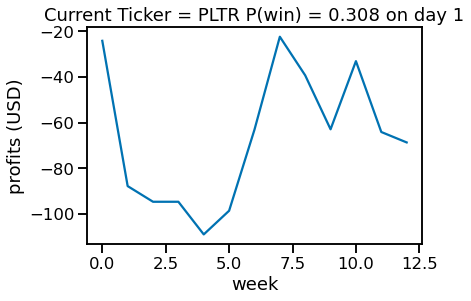

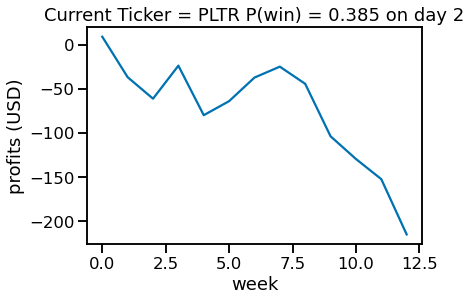

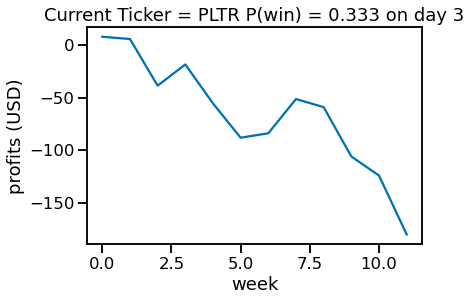

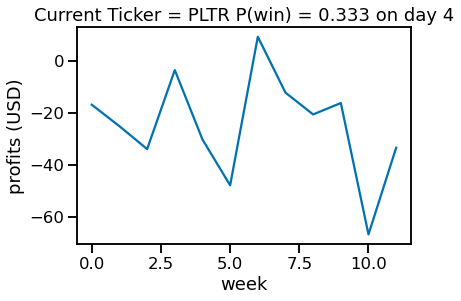

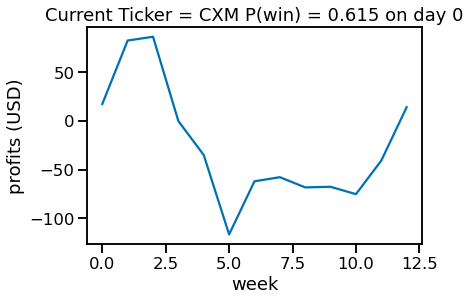

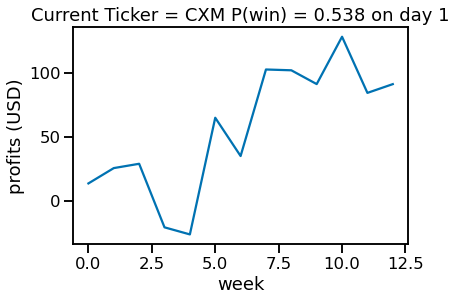

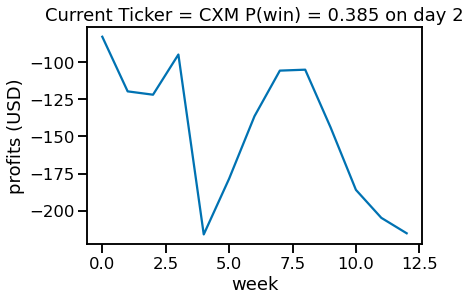

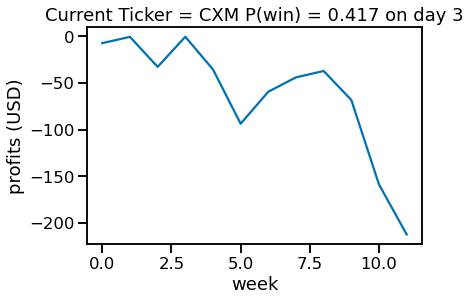

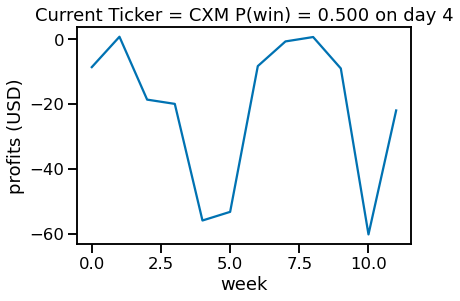

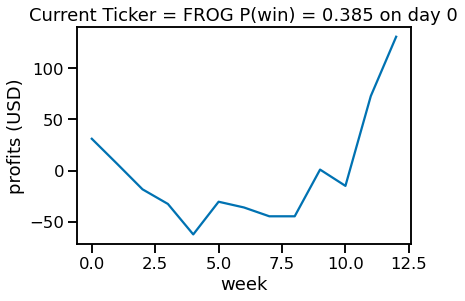

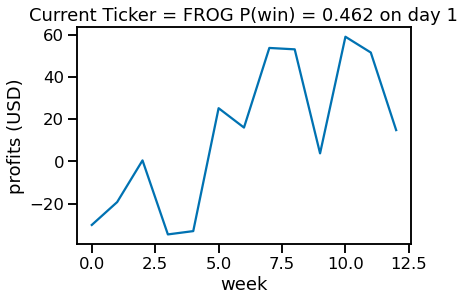

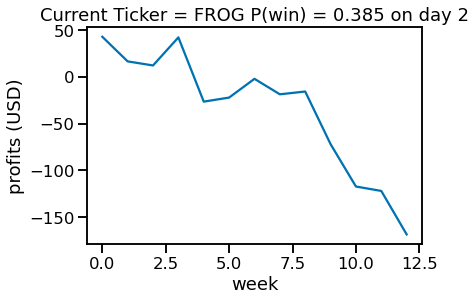

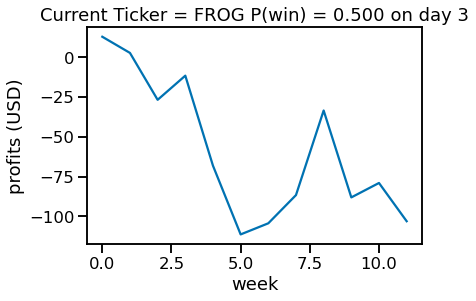

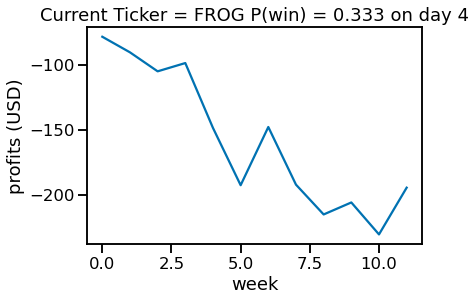

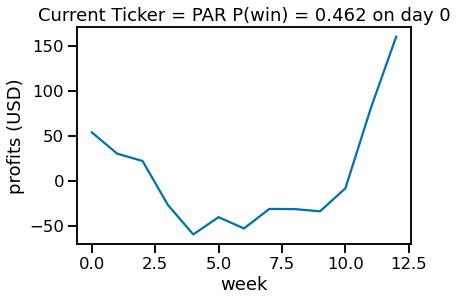

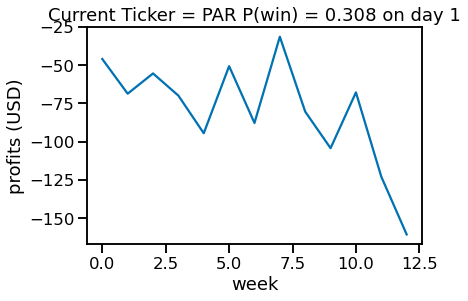

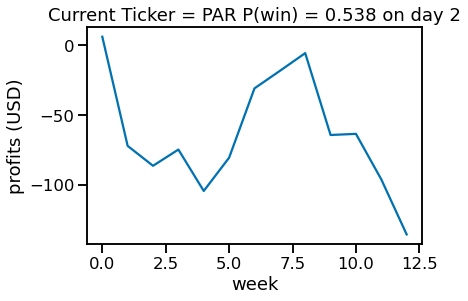

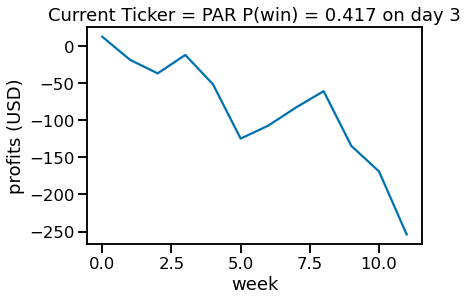

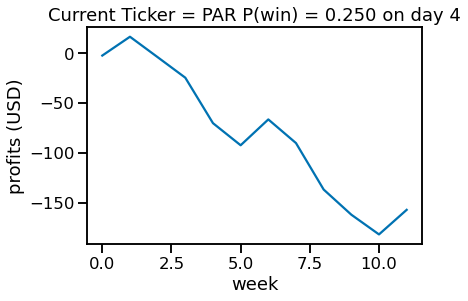

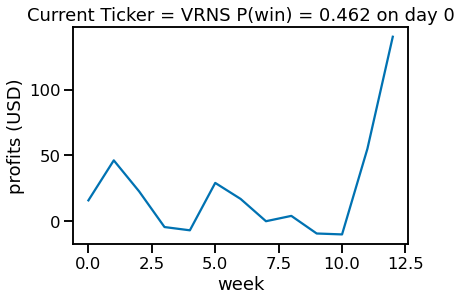

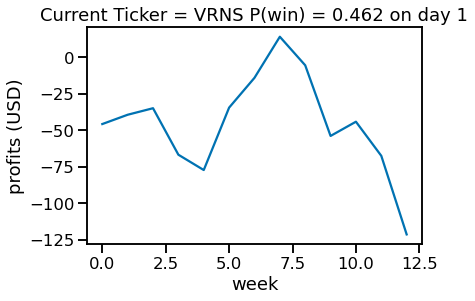

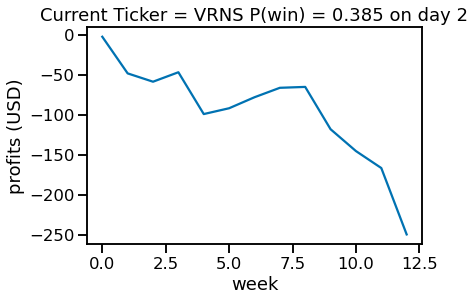

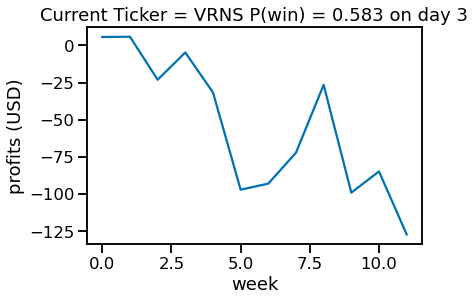

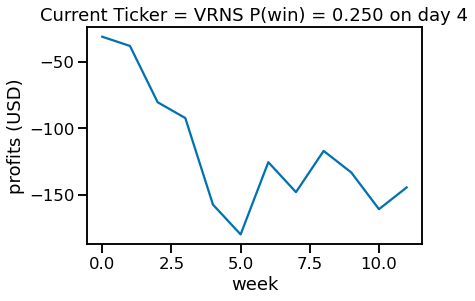

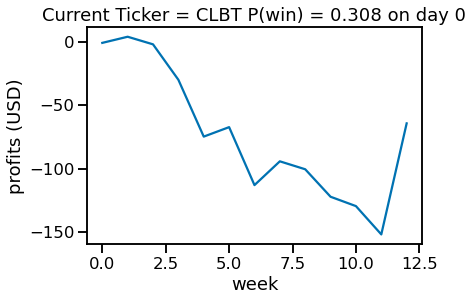

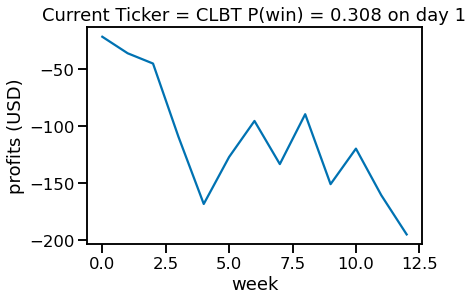

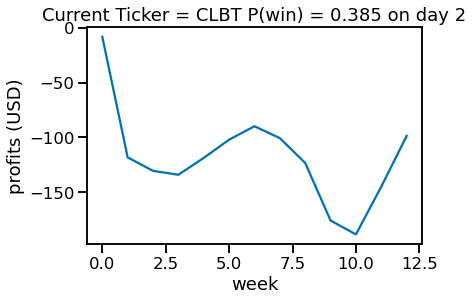

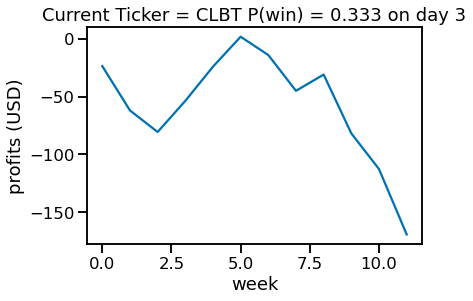

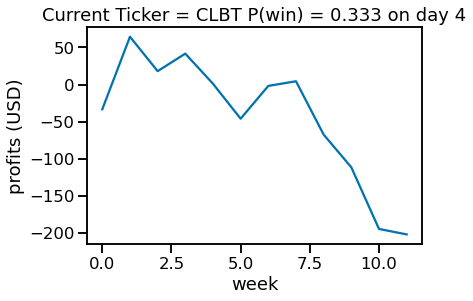

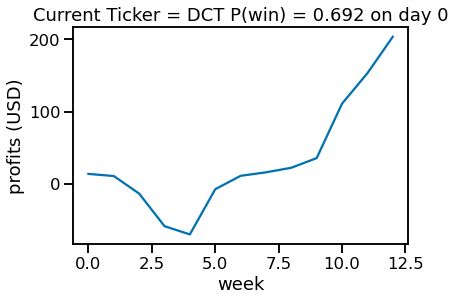

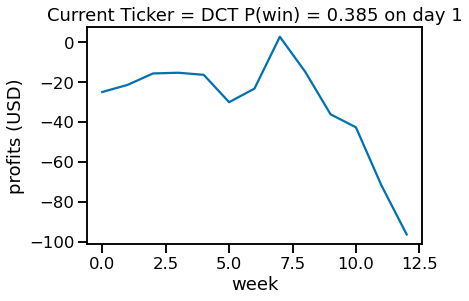

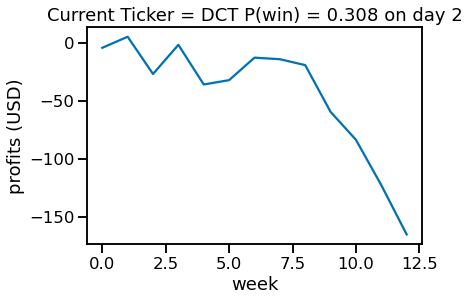

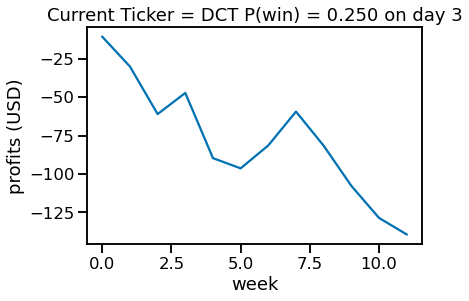

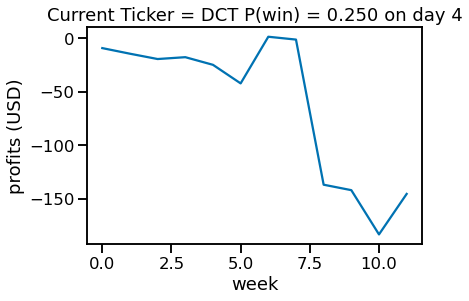

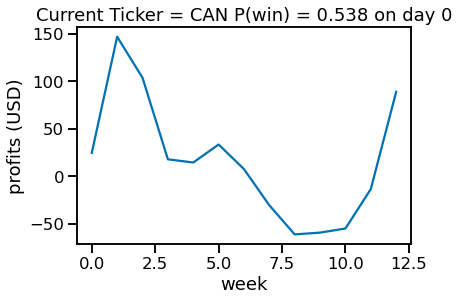

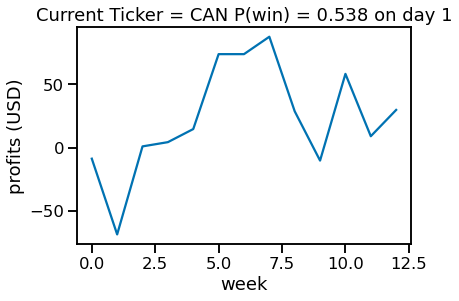

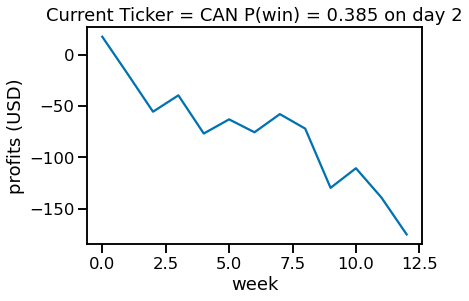

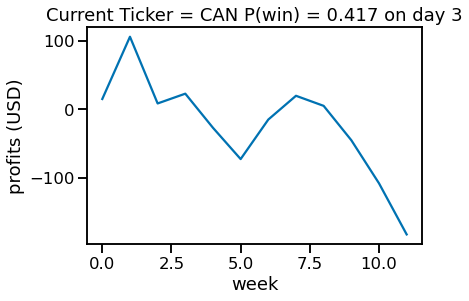

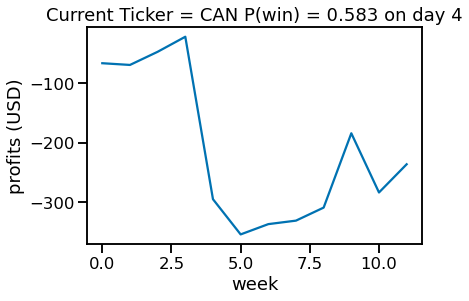

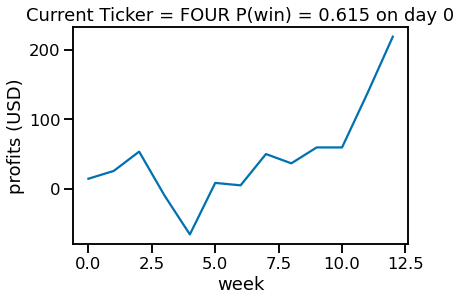

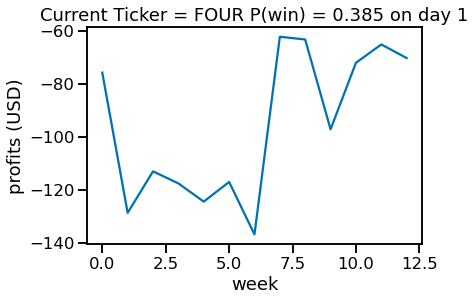

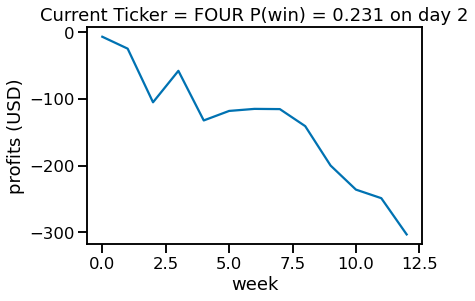

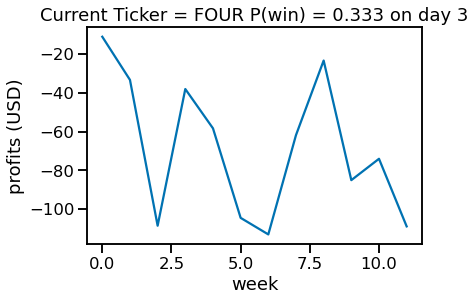

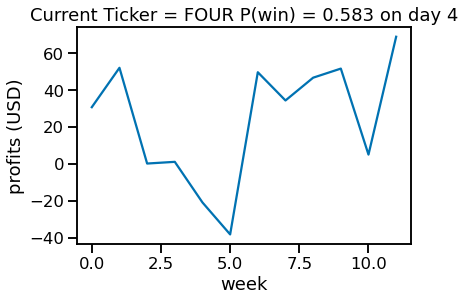

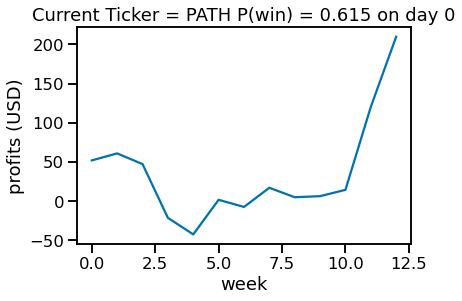

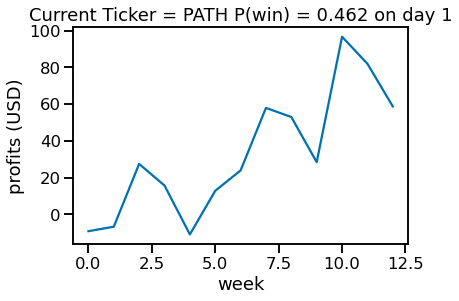

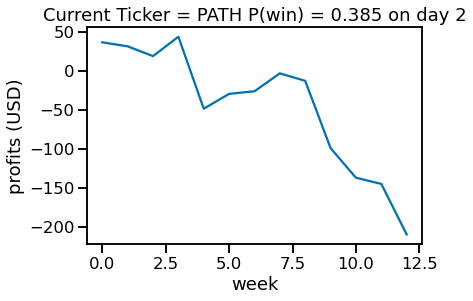

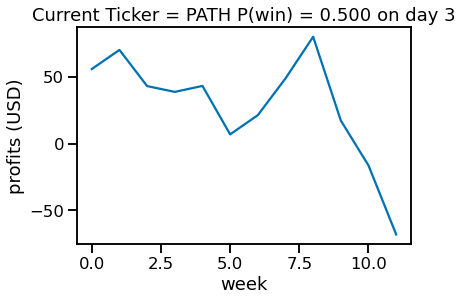

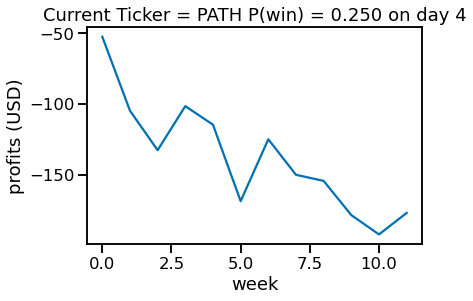

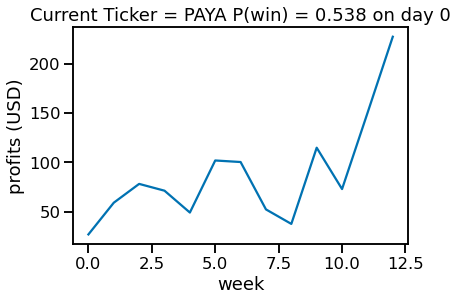

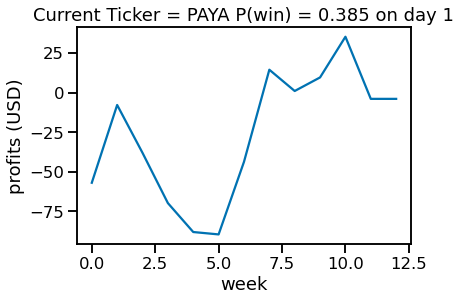

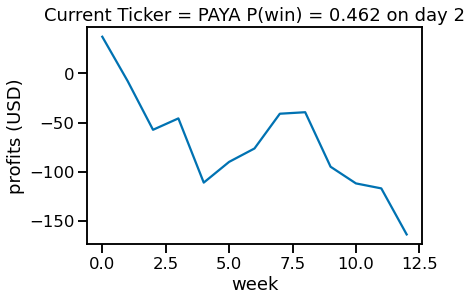

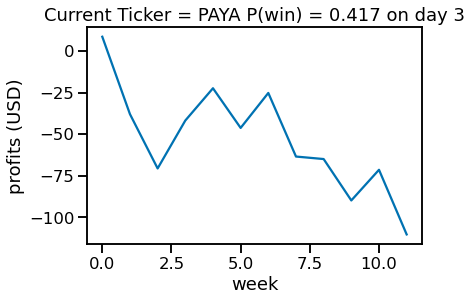

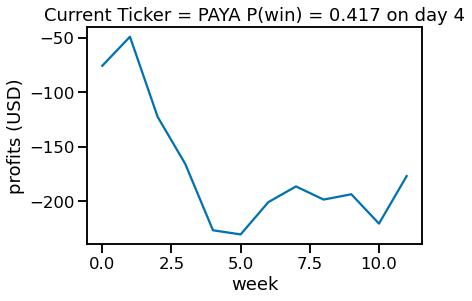

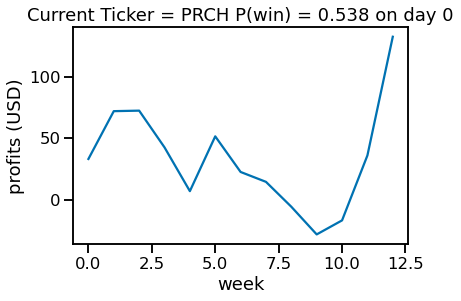

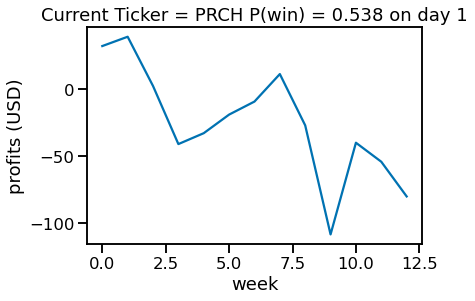

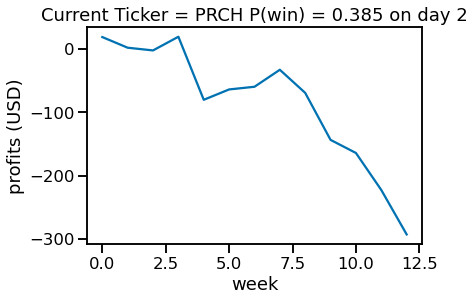

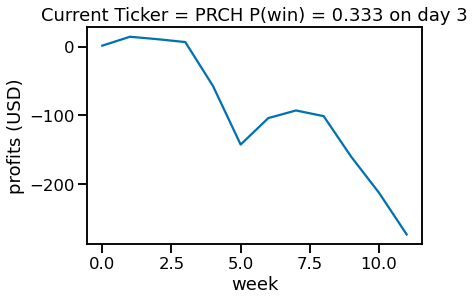

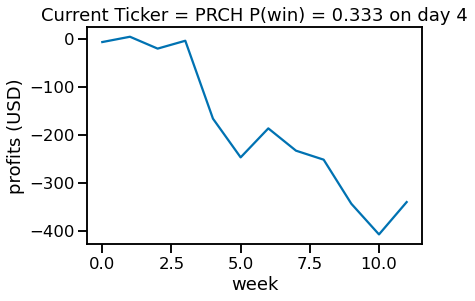

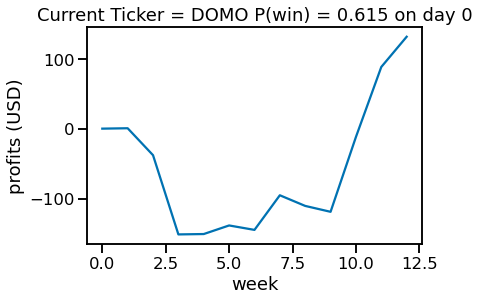

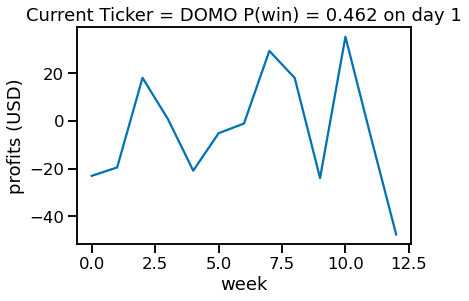

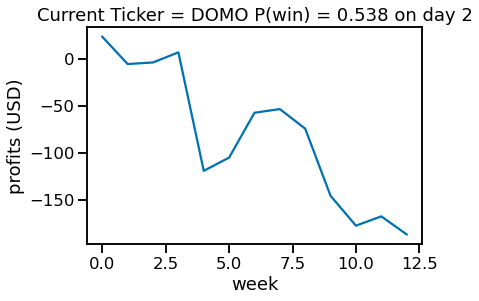

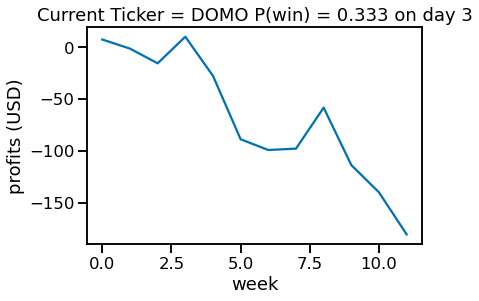

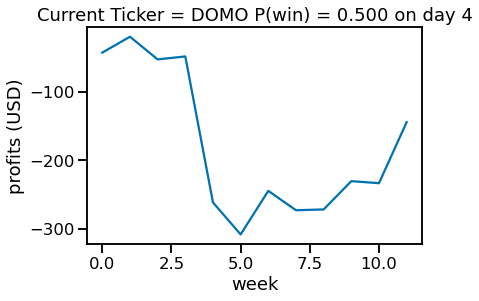

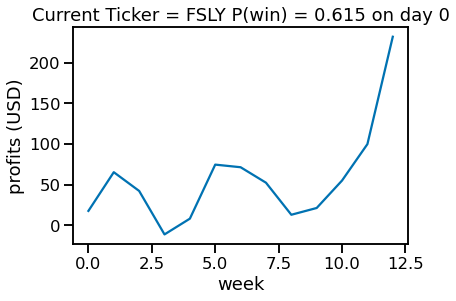

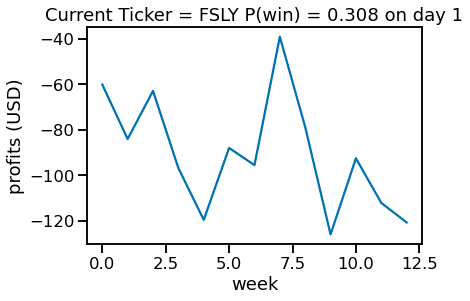

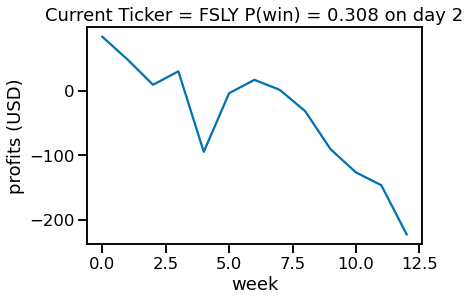

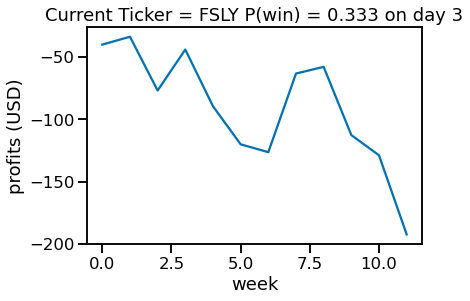

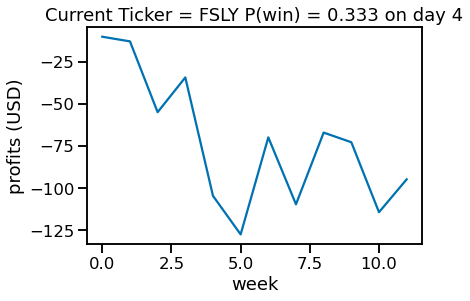

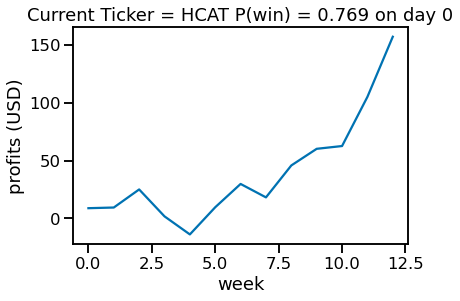

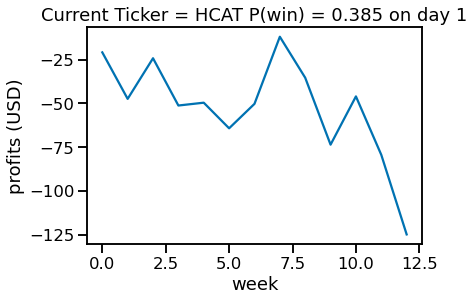

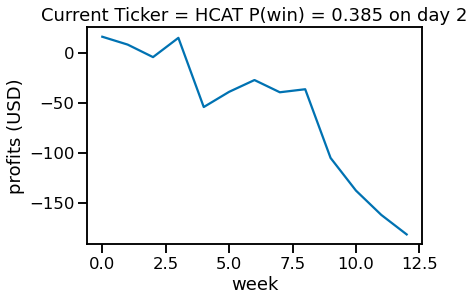

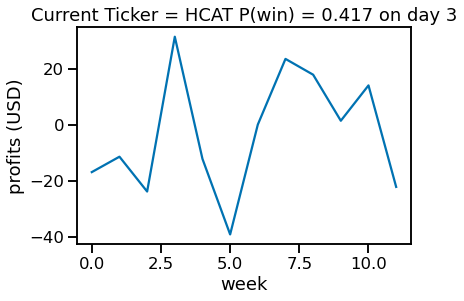

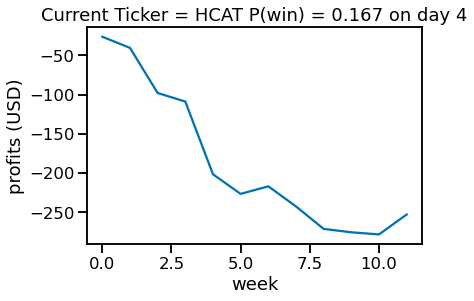

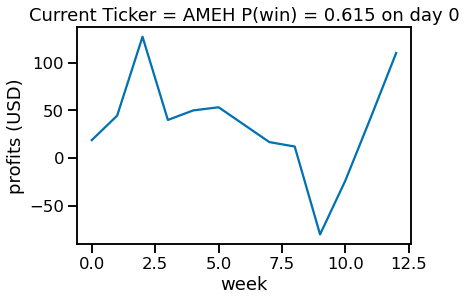

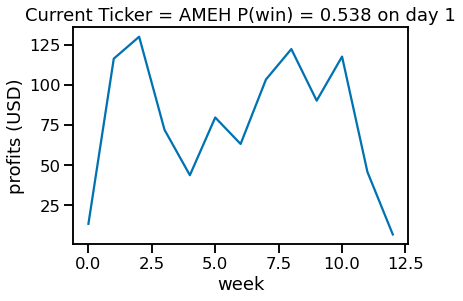

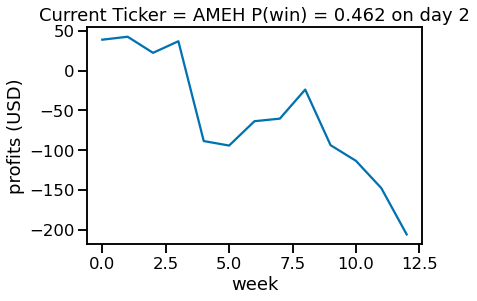

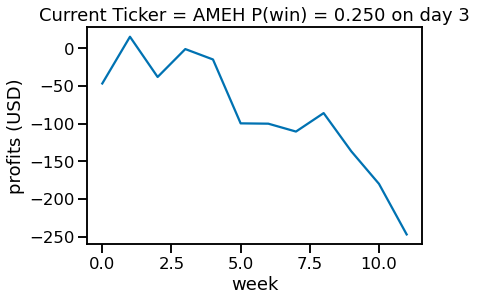

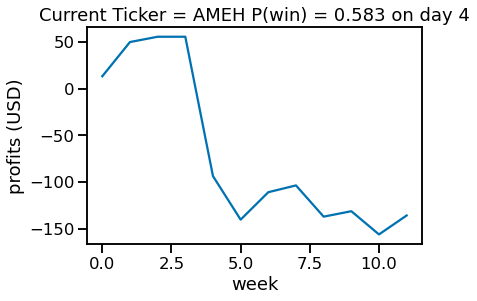

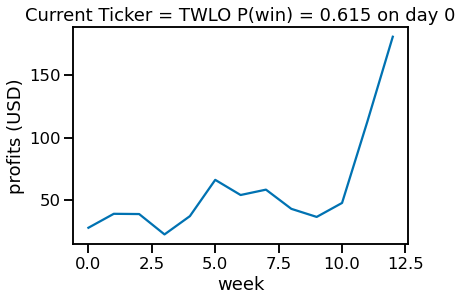

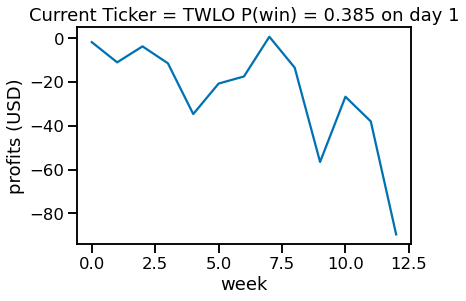

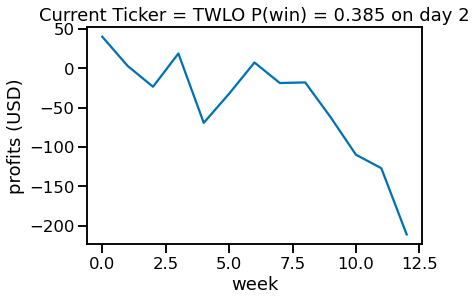

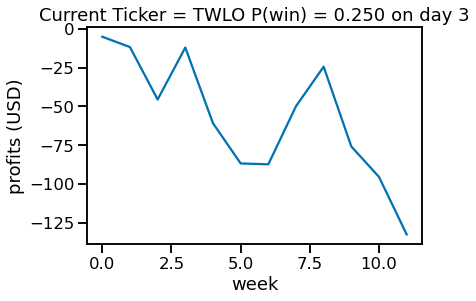

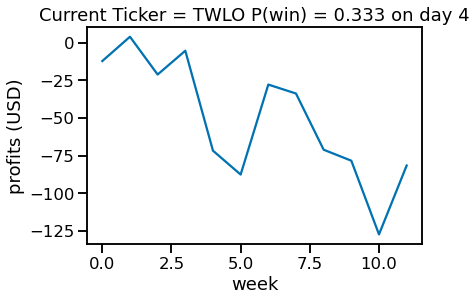

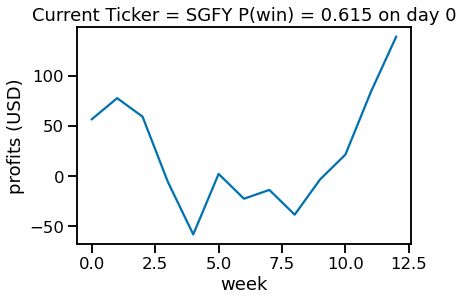

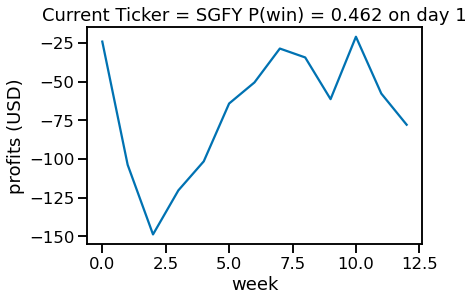

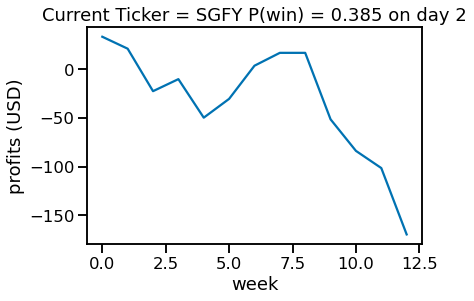

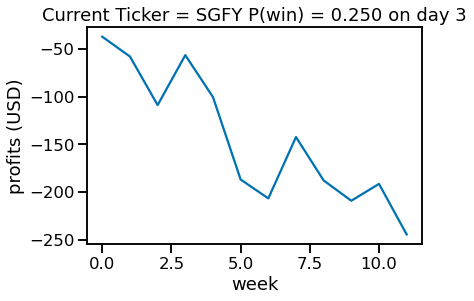

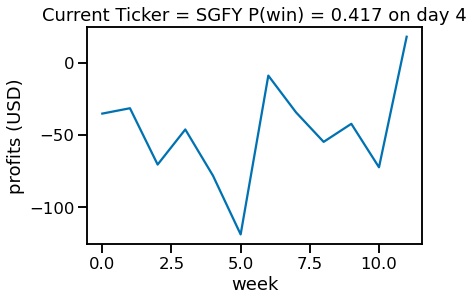

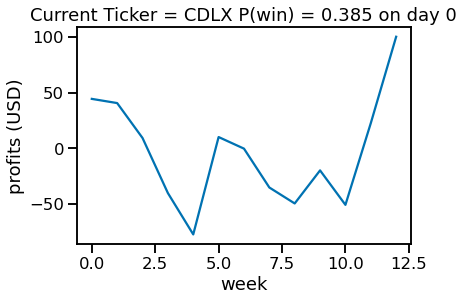

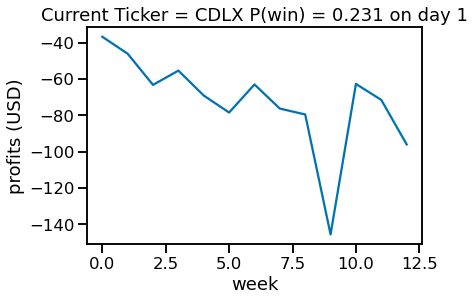

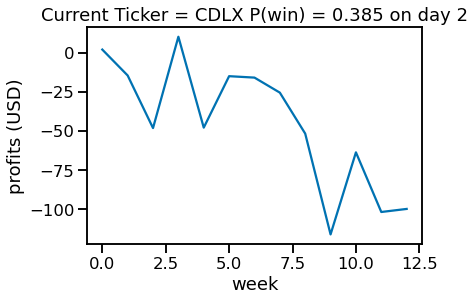

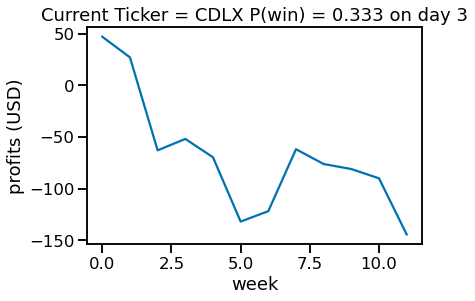

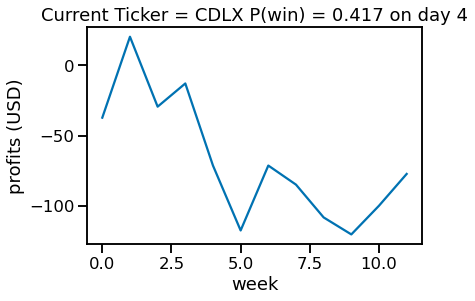

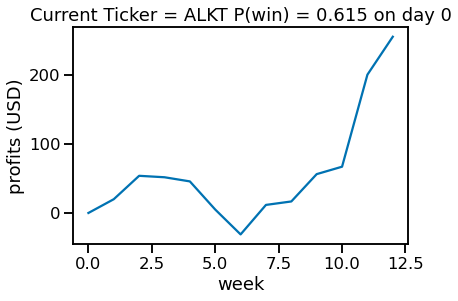

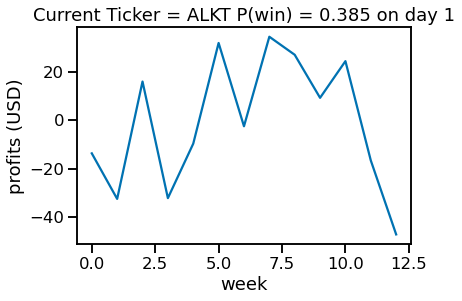

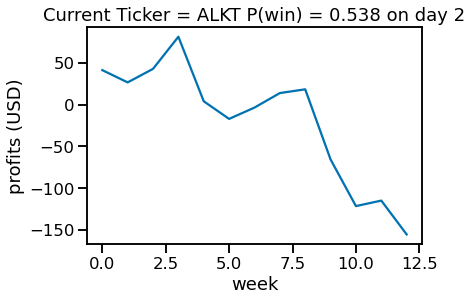

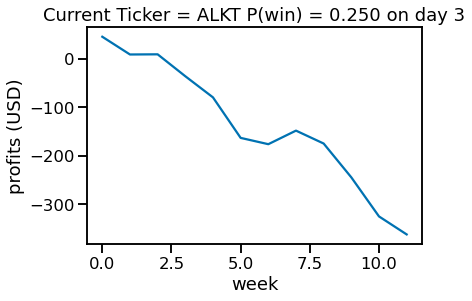

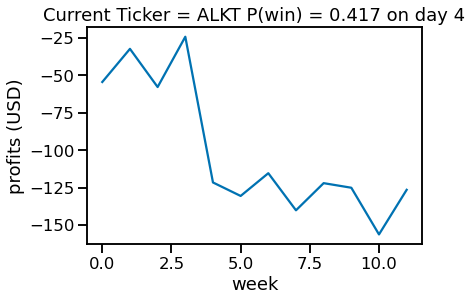

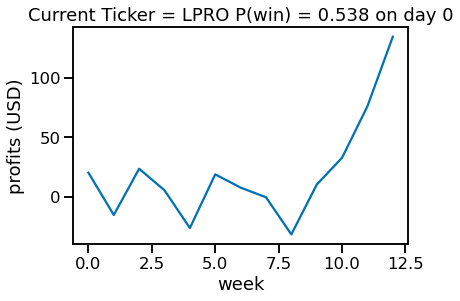

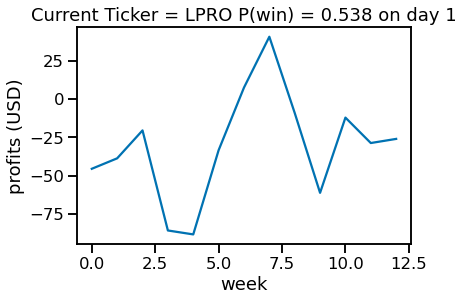

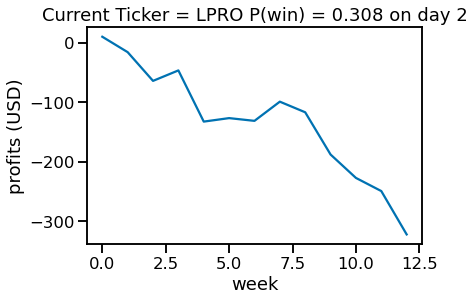

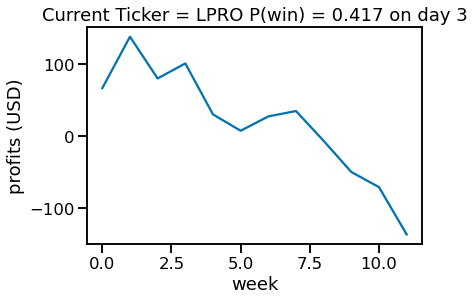

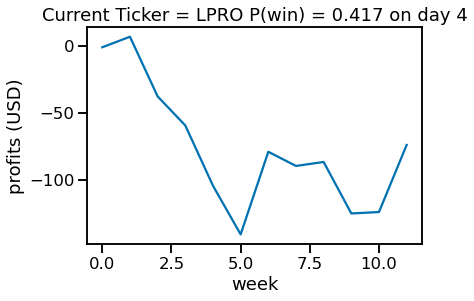

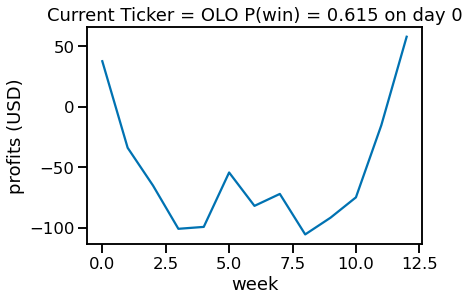

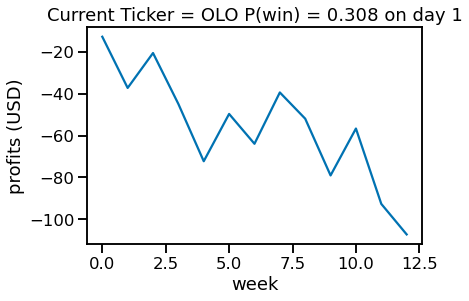

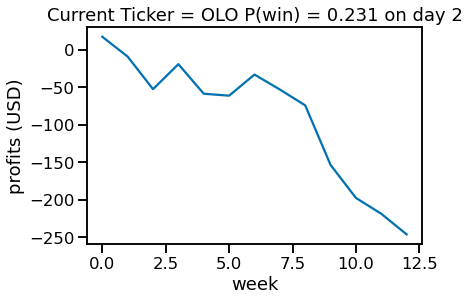

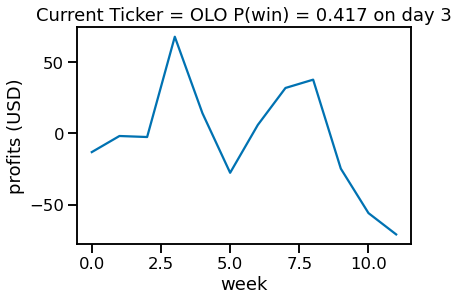

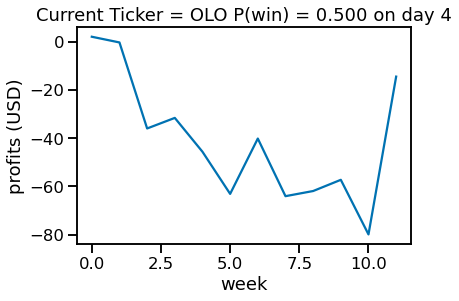

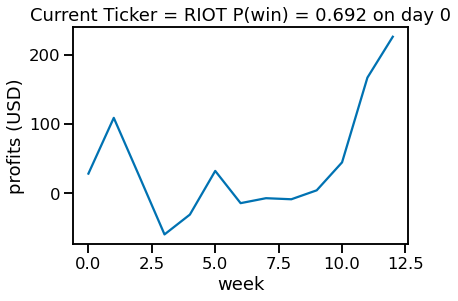

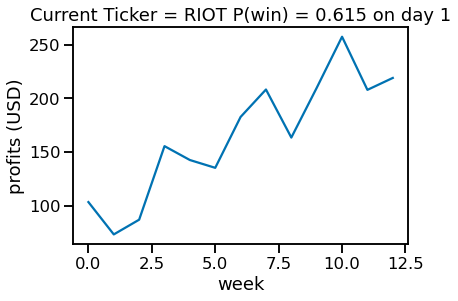

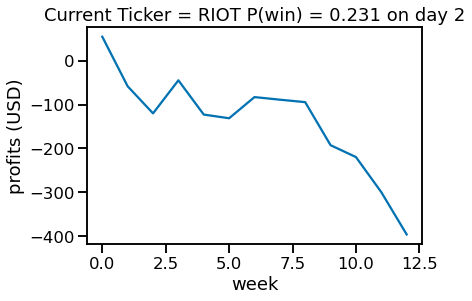

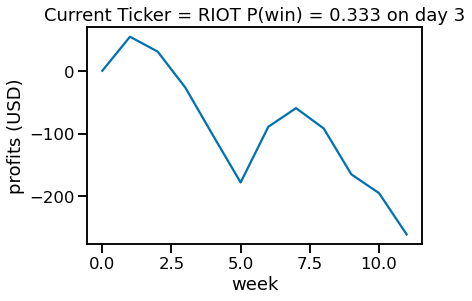

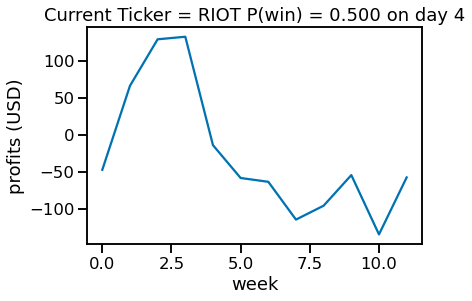

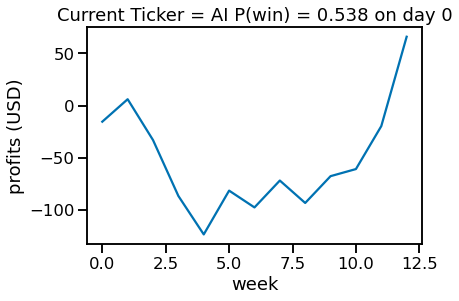

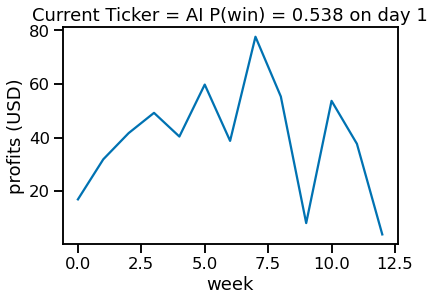

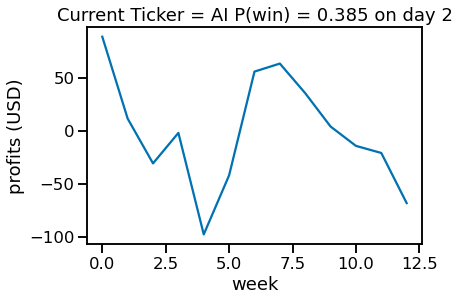

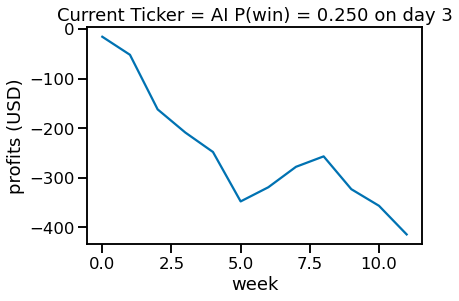

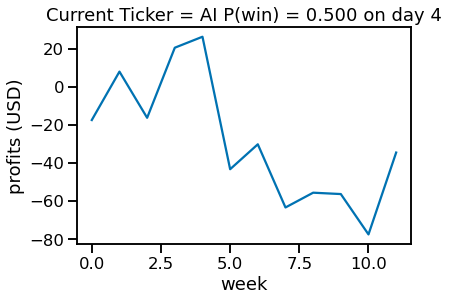

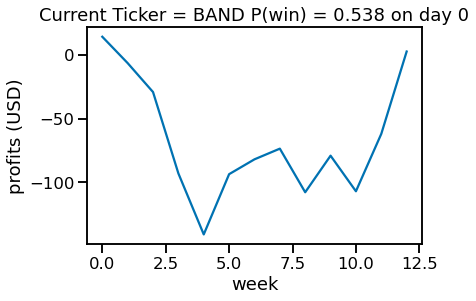

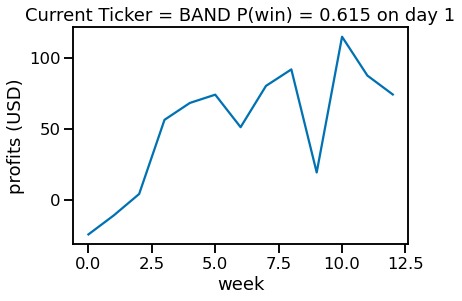

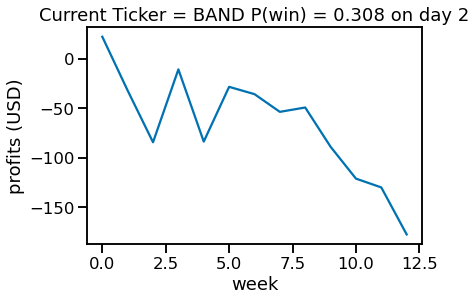

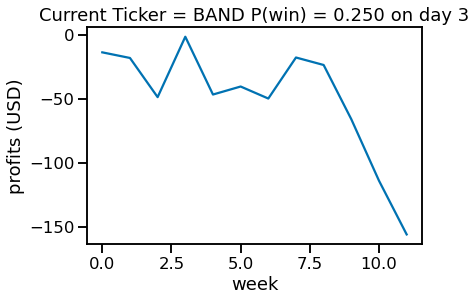

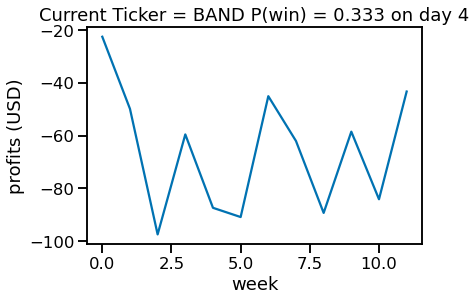

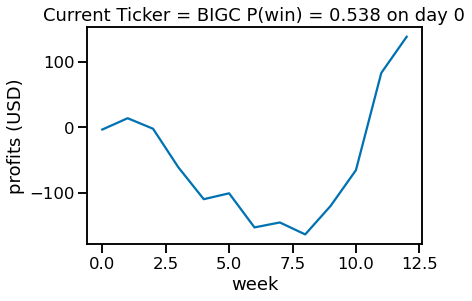

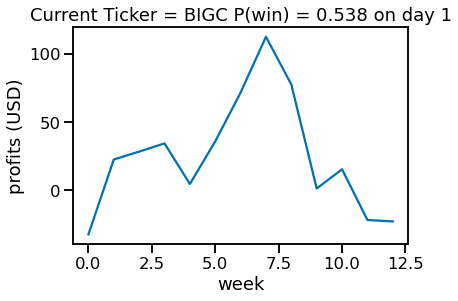

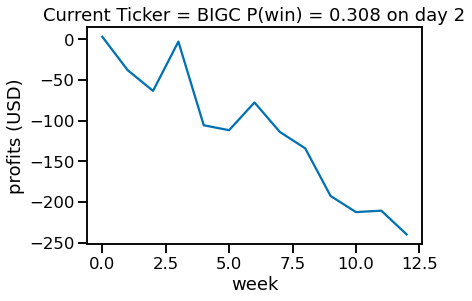

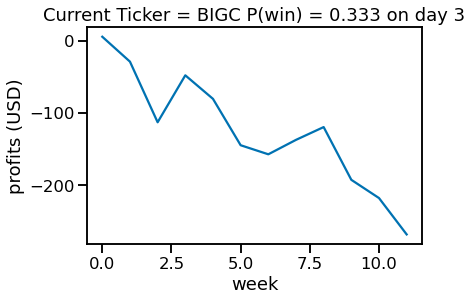

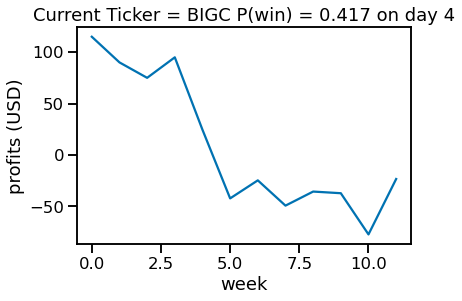

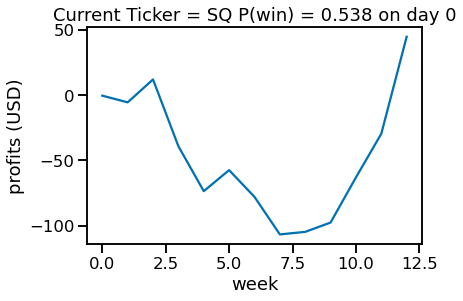

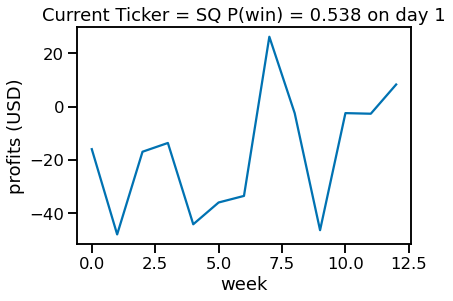

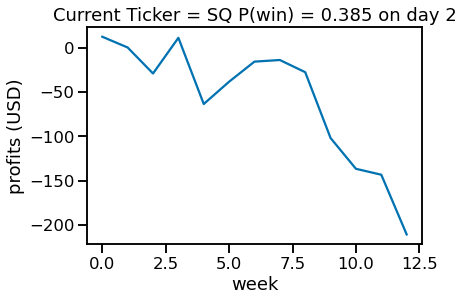

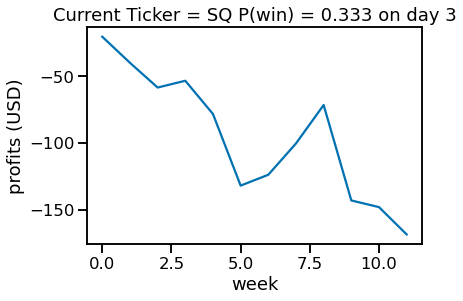

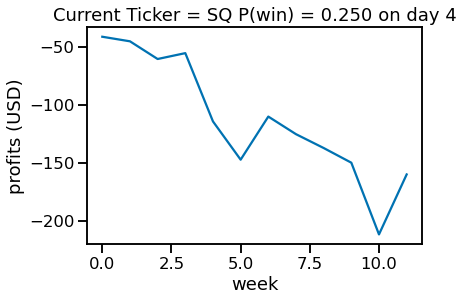

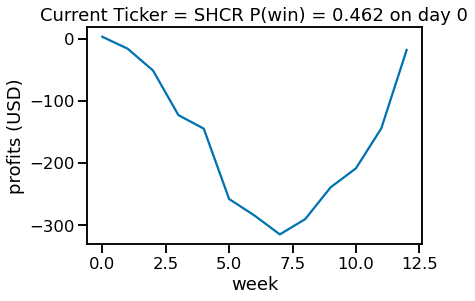

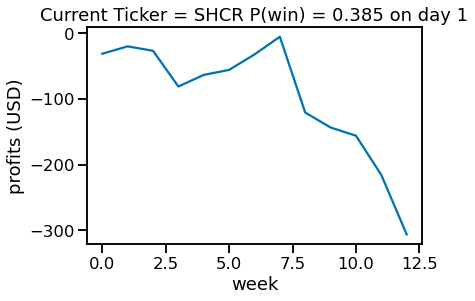

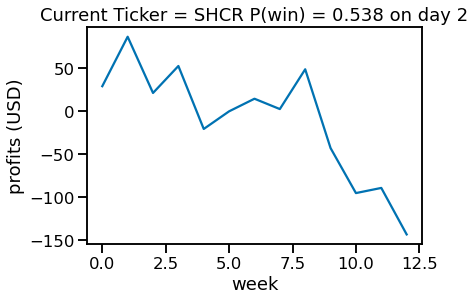

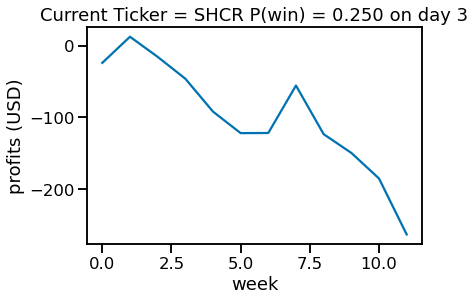

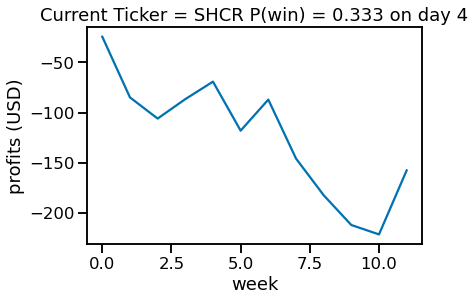

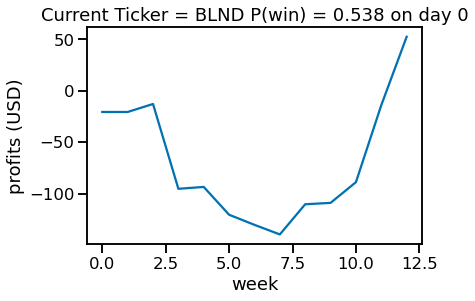

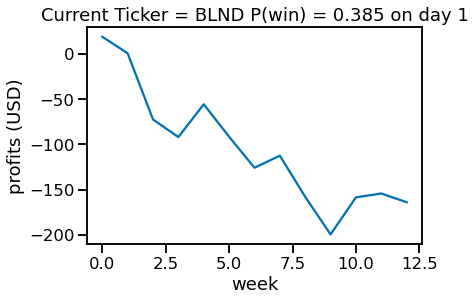

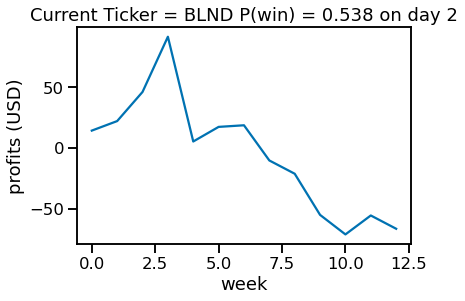

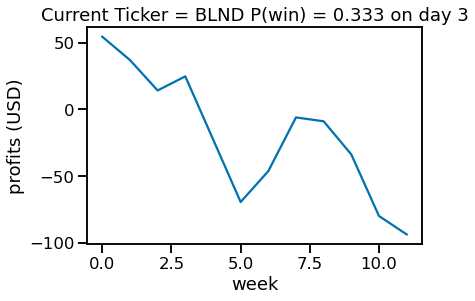

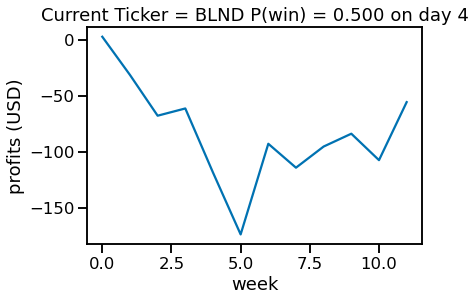

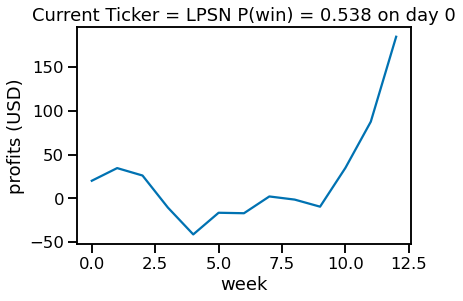

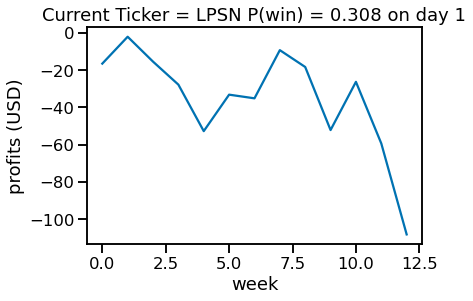

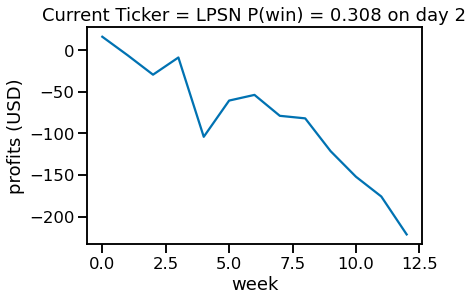

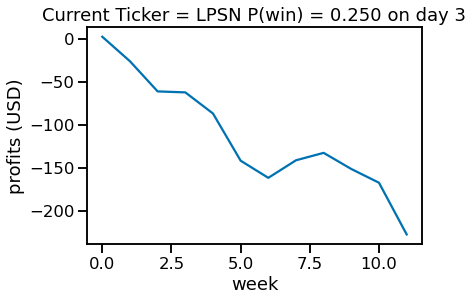

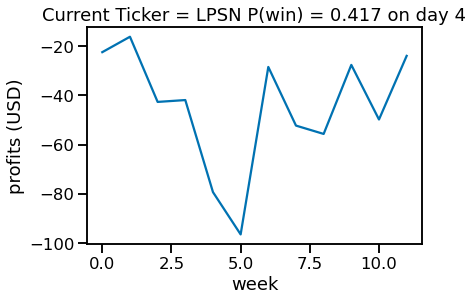

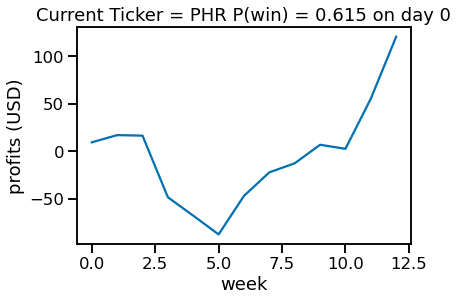

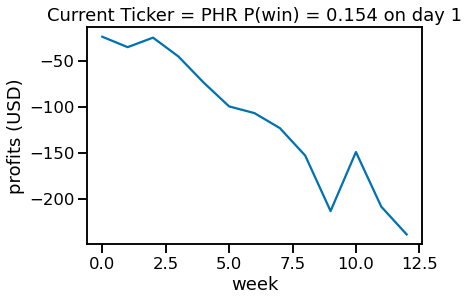

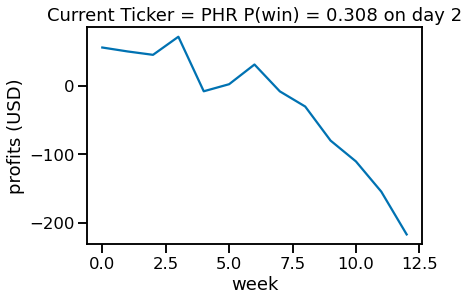

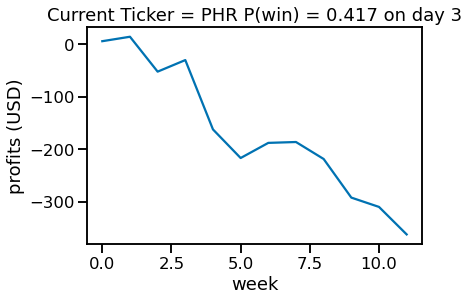

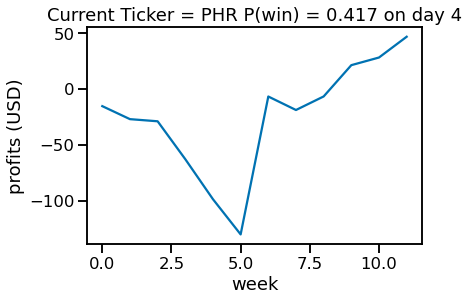

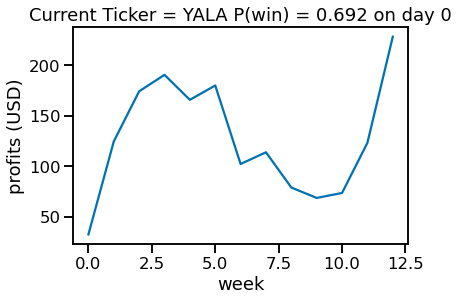

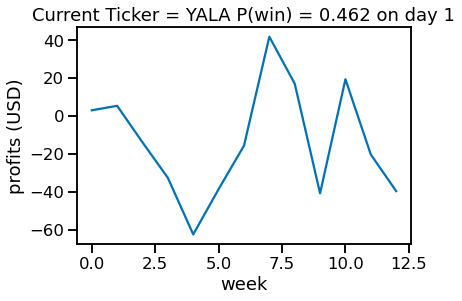

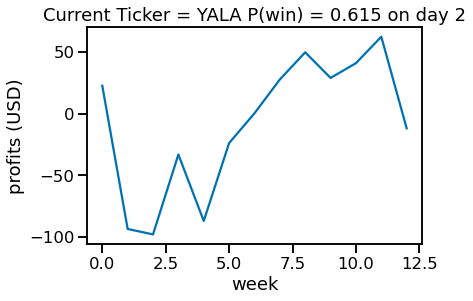

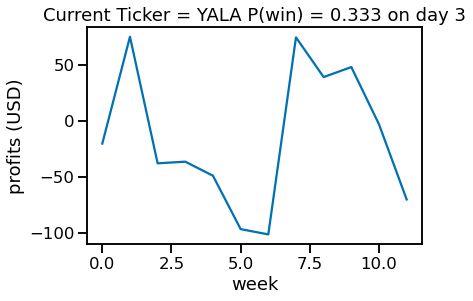

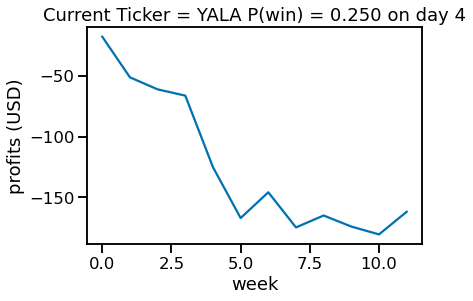

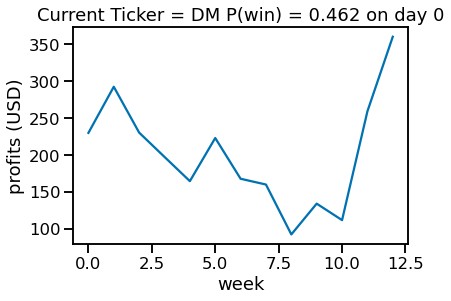

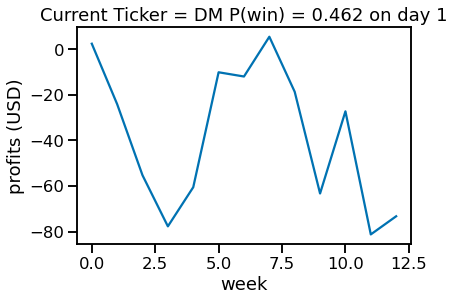

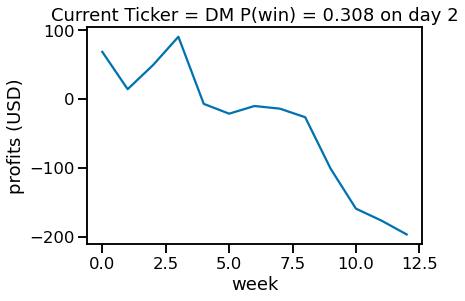

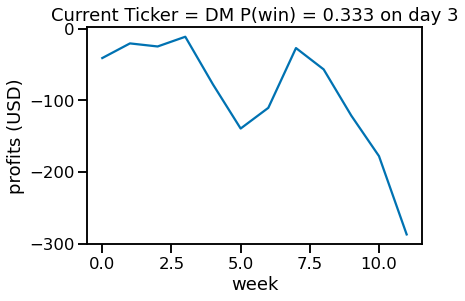

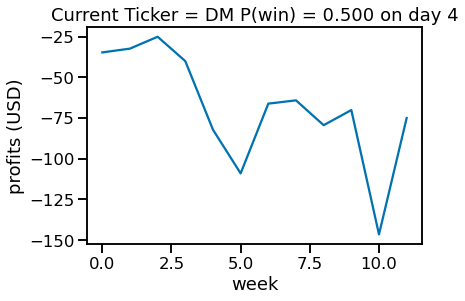

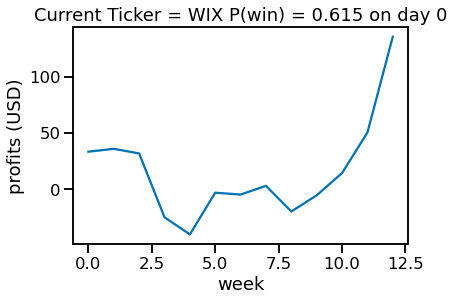

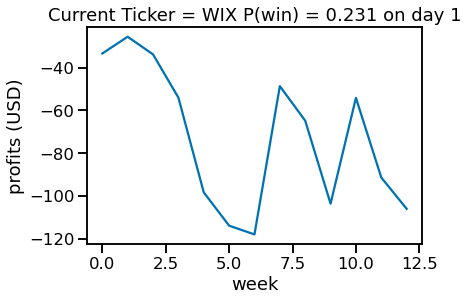

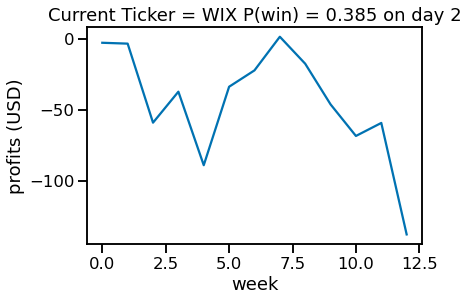

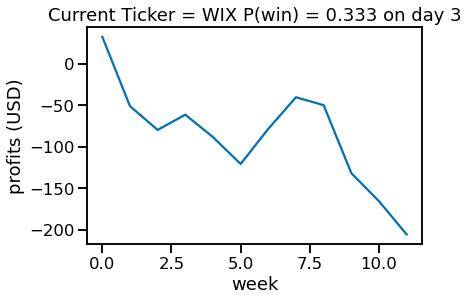

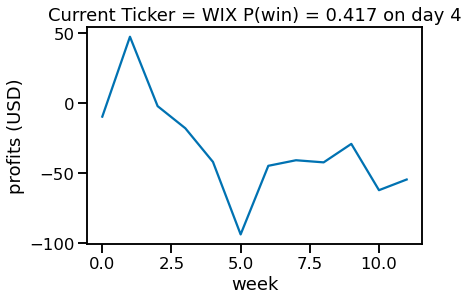

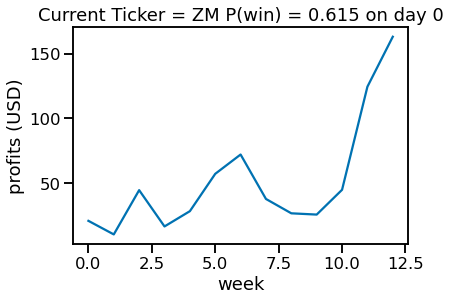

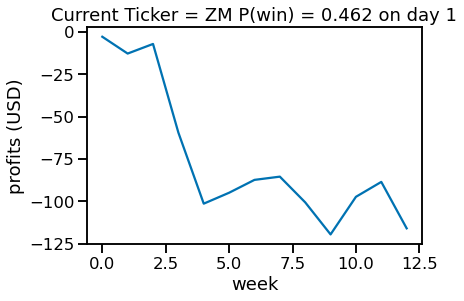

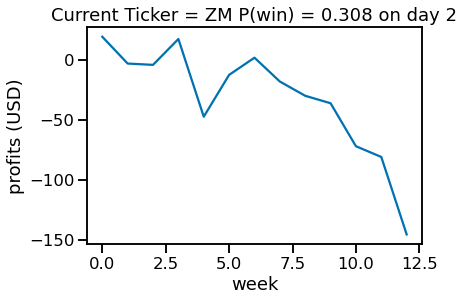

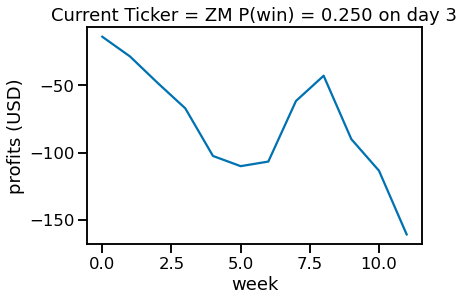

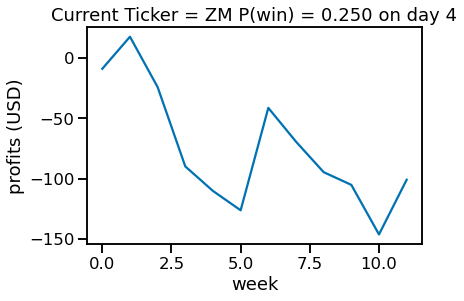

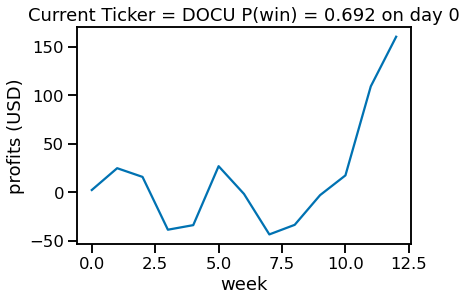

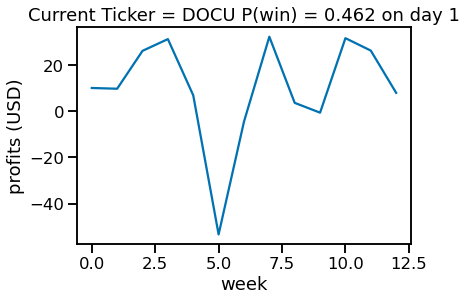

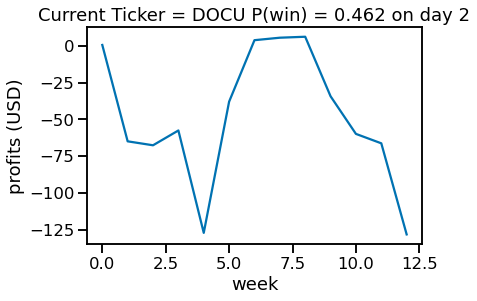

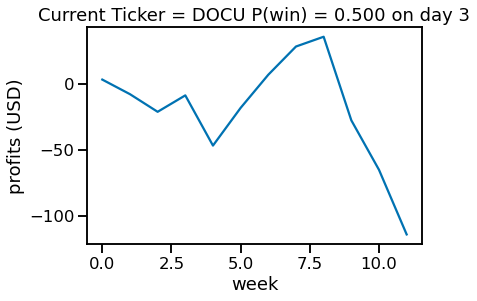

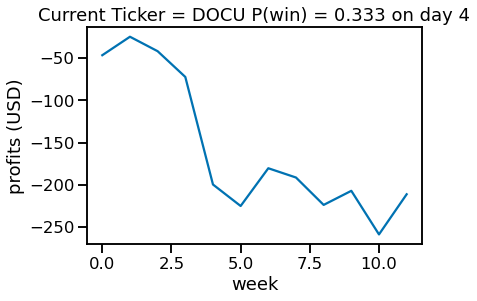

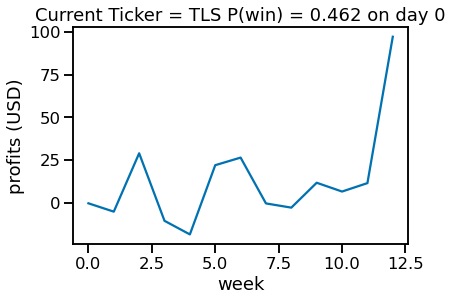

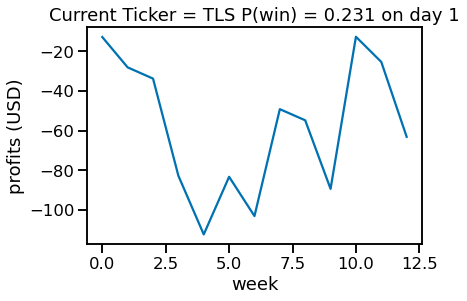

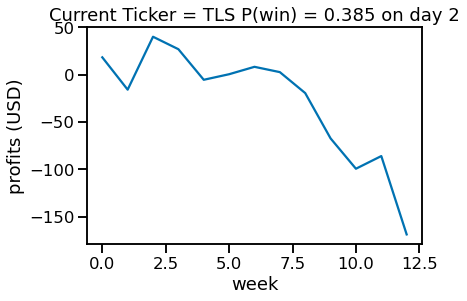

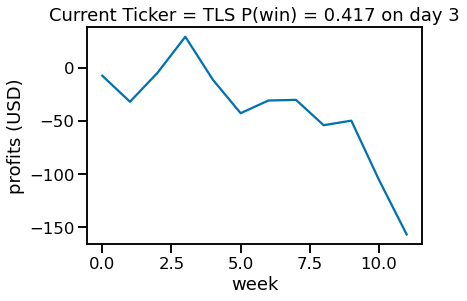

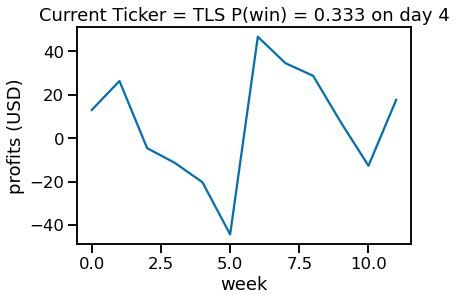

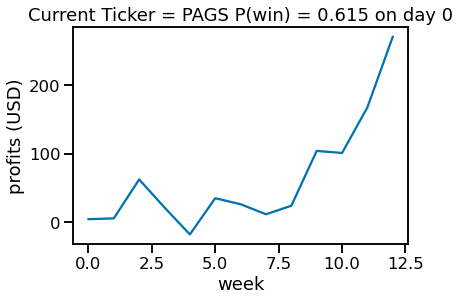

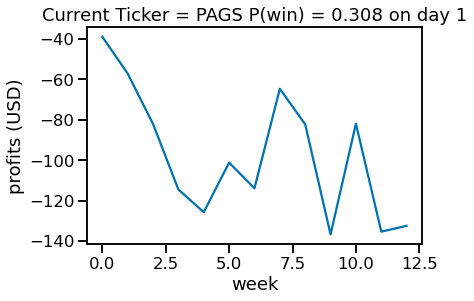

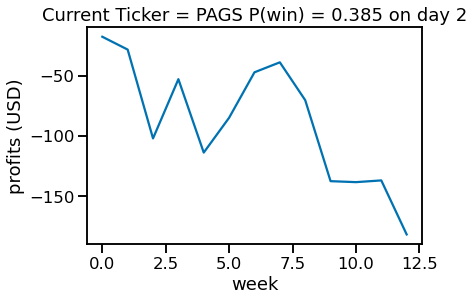

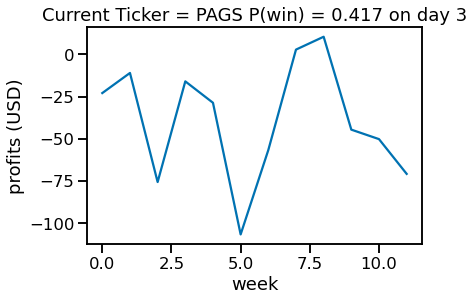

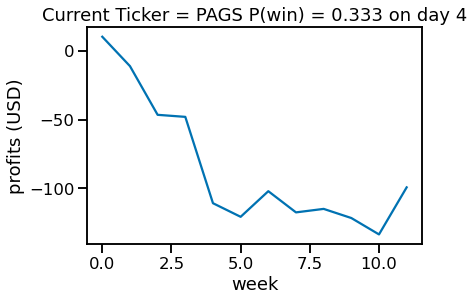

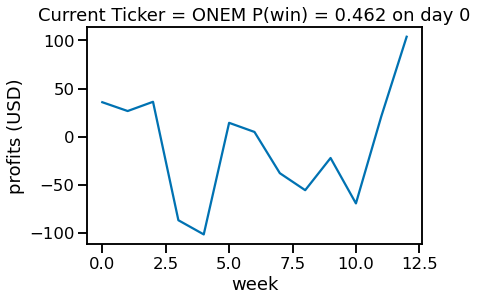

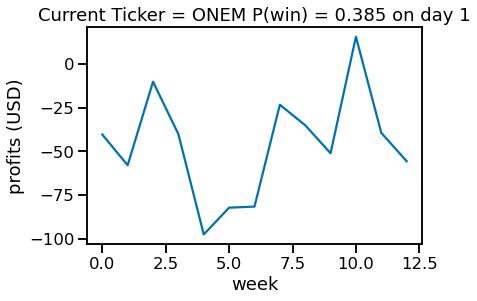

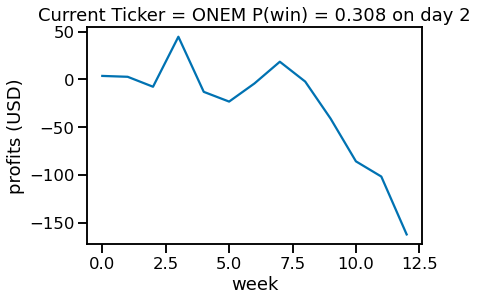

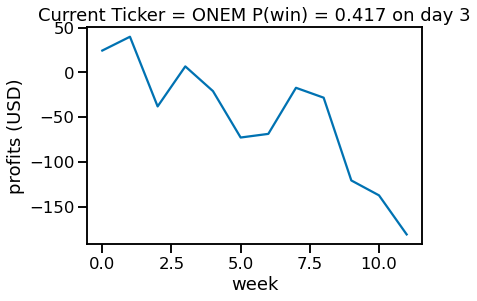

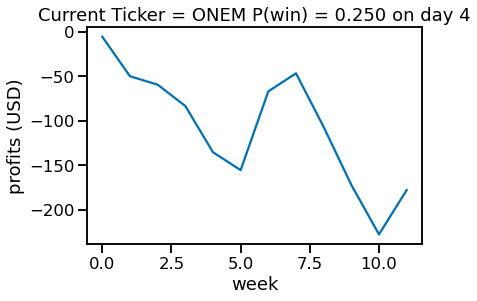

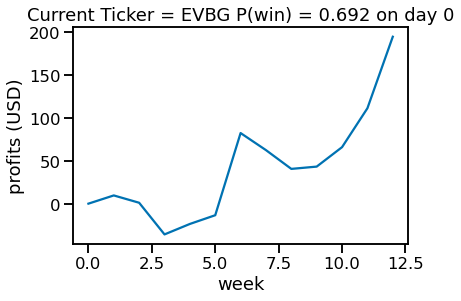

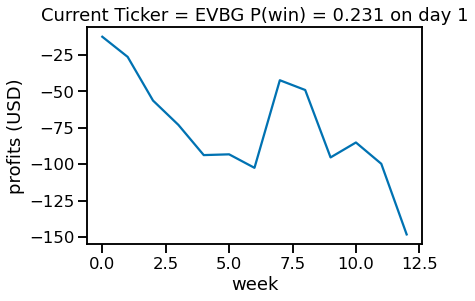

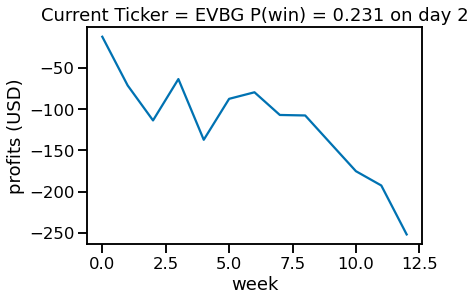

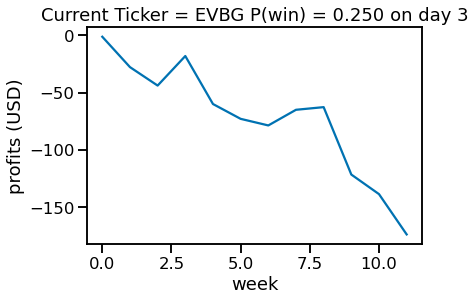

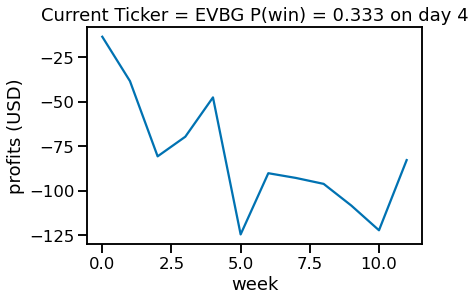

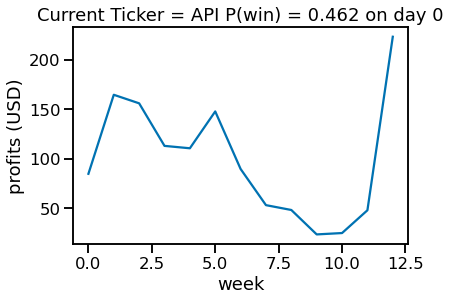

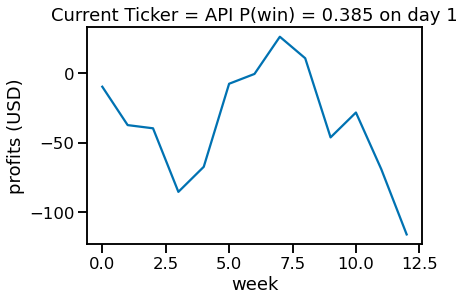

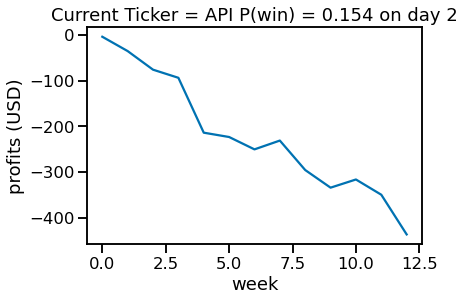

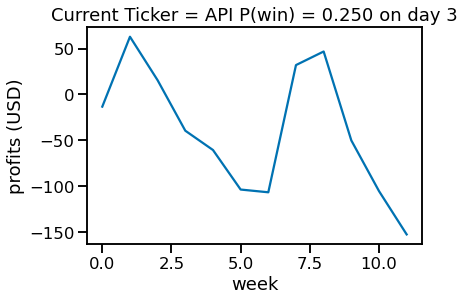

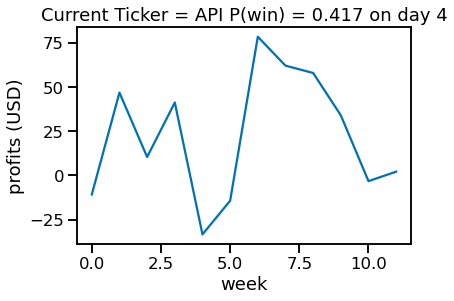

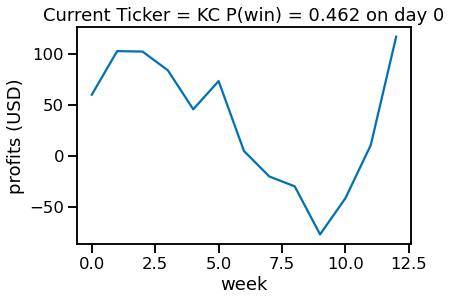

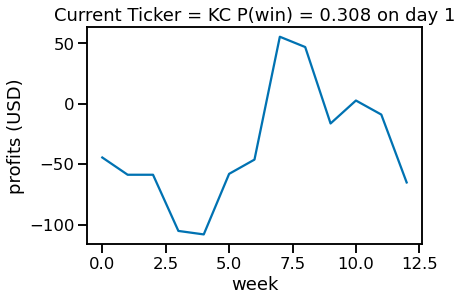

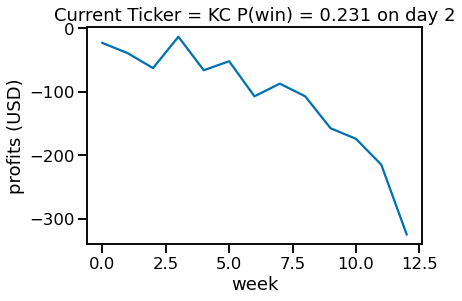

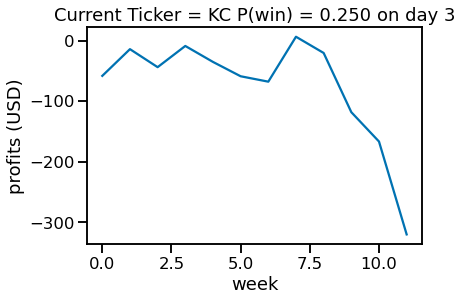

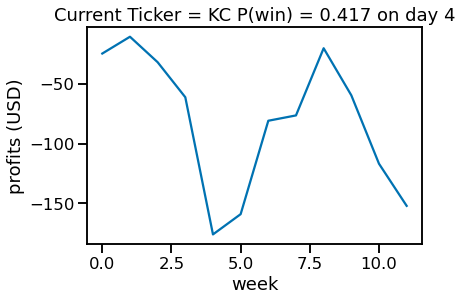

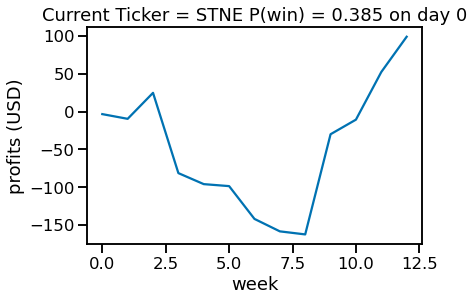

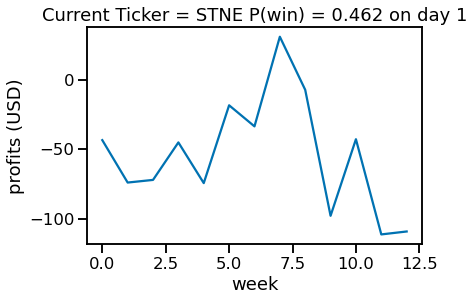

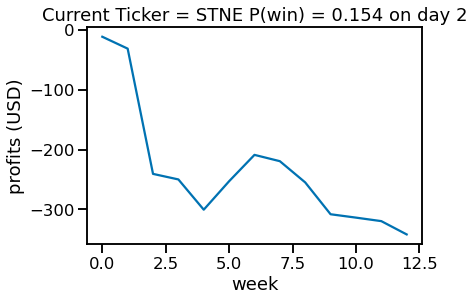

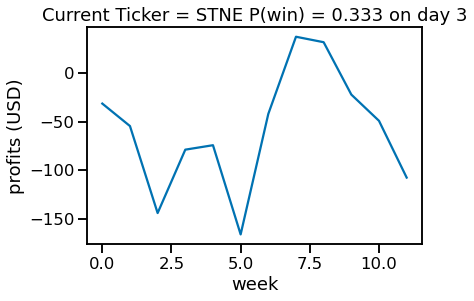

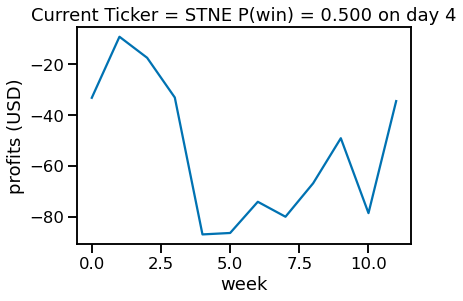

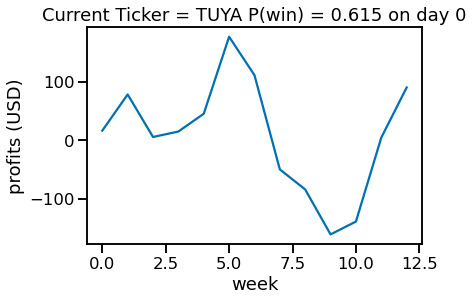

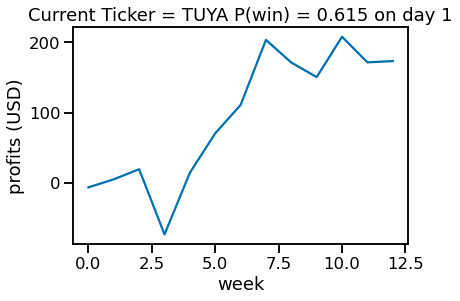

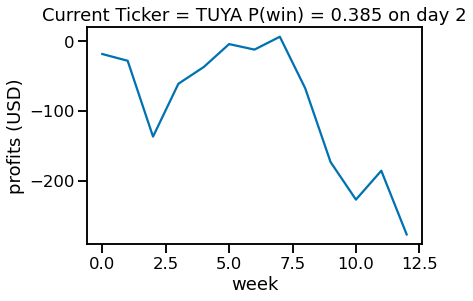

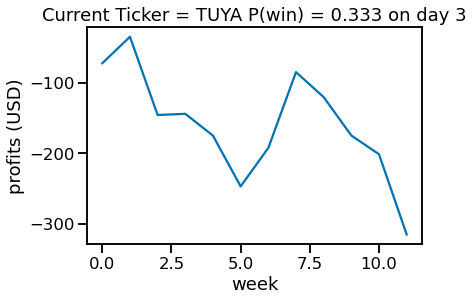

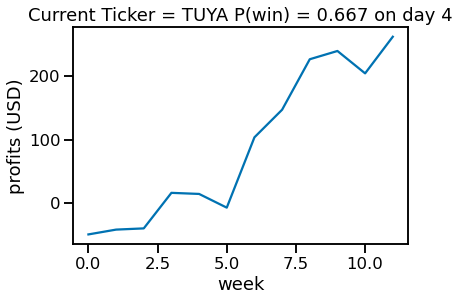

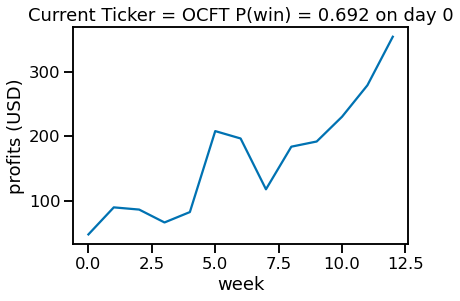

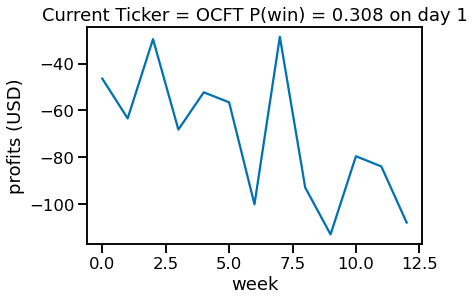

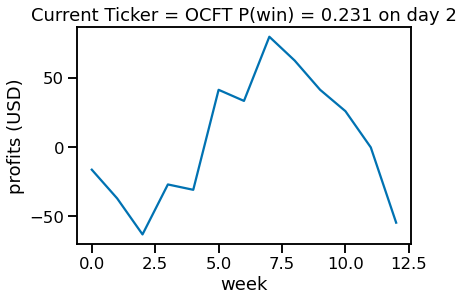

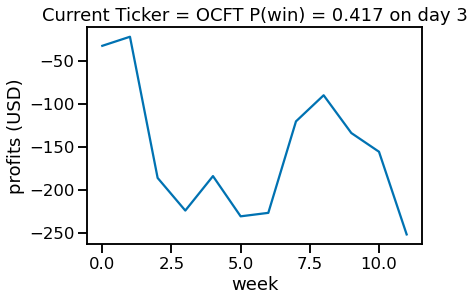

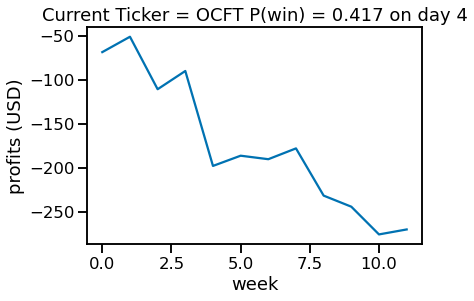

In [24]:
import plotly.express as px

backtest_data = pd.DataFrame()

for ticker, data in historical_data.items():
    # print(f'Current Ticker: {ticker}')
    for i in range(0,5):
        profits = backtest(data, day= i)
        # backtest_data.append(profits)
        plot_profits(ticker, profits, day = i) 

backtest_data.head()
    